# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [332]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum 

import datetime
import calendar

from pyspark.sql import Window
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sb
%matplotlib inline

import re
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import regexp_extract, col,  regexp_replace, split
from pyspark.sql.functions import create_map, lit
from itertools import chain


# ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler, MinMaxScaler, RobustScaler
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_path = "mini_sparkify_event_data.json"
df = spark.read.json(data_path)

In [4]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Preliminary Data Wrangling
We will perform some preliminary data wrangling before doing EDA in exploring some of the problem such as missing data and incorrect format. We will mostly used pandas in this step for better visualization and navigation. 

In [7]:
df1 = df.toPandas()
df1.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


So we can see that there is a format problem with time stamp and registration and we need to extract the necessary string for our data in both location and userAgent. 

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           286500 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  286500 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          286500 non-null  object 
 8   location       278154 non-null  object 
 9   method         286500 non-null  object 
 10  page           286500 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      286500 non-null  int64  
 13  song           228108 non-null  object 
 14  status         286500 non-null  int64  
 15  ts             286500 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         286500 non-nul

- artist, song, length have same number which most likely that this number is related to the Song page activities
- name, gender, location, registration, user agent have same number but different number wuth the biggest non-null number of 286500 which means that the missing value is related with the guest that did not sign in

In [9]:
df1['userId'].value_counts()

39        9632
          8346
92        7230
140       6880
300011    5732
          ... 
300003      35
100011      23
125         11
156          6
135          6
Name: userId, Length: 226, dtype: int64

This confirmed the customer data-related missing values is related with guest that did not sign in. 

So we will: 
1. discard missing value since we don't know which guest do which activities 
2. give the timestamp and registartion time the correct format 
3. extract the necessary part from location and userAgent 
4. crating churn and downgrade column 

#### Removing Missing Value 

In [10]:
df1.isna().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

The missing entry from NaN value will be removed except artist, song, length NaN column due to their entry will not appear if customer visit non-song related page

In [11]:
df2 = df1.dropna(subset=['firstName'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278154 entries, 0 to 286499
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   artist         228108 non-null  object 
 1   auth           278154 non-null  object 
 2   firstName      278154 non-null  object 
 3   gender         278154 non-null  object 
 4   itemInSession  278154 non-null  int64  
 5   lastName       278154 non-null  object 
 6   length         228108 non-null  float64
 7   level          278154 non-null  object 
 8   location       278154 non-null  object 
 9   method         278154 non-null  object 
 10  page           278154 non-null  object 
 11  registration   278154 non-null  float64
 12  sessionId      278154 non-null  int64  
 13  song           228108 non-null  object 
 14  status         278154 non-null  int64  
 15  ts             278154 non-null  int64  
 16  userAgent      278154 non-null  object 
 17  userId         278154 non-nul

In [12]:
df1['auth'].value_counts(), df1['page'].value_counts()

(Logged In     278102
 Logged Out      8249
 Guest             97
 Cancelled         52
 Name: auth, dtype: int64,
 NextSong                     228108
 Home                          14457
 Thumbs Up                     12551
 Add to Playlist                6526
 Add Friend                     4277
 Roll Advert                    3933
 Login                          3241
 Logout                         3226
 Thumbs Down                    2546
 Downgrade                      2055
 Help                           1726
 Settings                       1514
 About                           924
 Upgrade                         499
 Save Settings                   310
 Error                           258
 Submit Upgrade                  159
 Submit Downgrade                 63
 Cancellation Confirmation        52
 Cancel                           52
 Register                         18
 Submit Registration               5
 Name: page, dtype: int64)

In [13]:
df2['auth'].value_counts(), df2['page'].value_counts()

(Logged In    278102
 Cancelled        52
 Name: auth, dtype: int64,
 NextSong                     228108
 Thumbs Up                     12551
 Home                          10082
 Add to Playlist                6526
 Add Friend                     4277
 Roll Advert                    3933
 Logout                         3226
 Thumbs Down                    2546
 Downgrade                      2055
 Settings                       1514
 Help                           1454
 Upgrade                         499
 About                           495
 Save Settings                   310
 Error                           252
 Submit Upgrade                  159
 Submit Downgrade                 63
 Cancel                           52
 Cancellation Confirmation        52
 Name: page, dtype: int64)

Comparing both the pages that disappeared after the changes of removing missing value, is related with registration and log in page. Next we will fix the format and the timestamp appereance of activities. 

#### Fix the timestamp and registration 

In [14]:
df2['act_time'] = df2['ts'].map((lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S")))
df2['act_time'].head()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    2018-10-01 07:01:57
1    2018-10-01 07:03:00
2    2018-10-01 07:06:34
3    2018-10-01 07:06:56
4    2018-10-01 07:11:16
Name: act_time, dtype: object

In [15]:
df2['regis_time'] = df2['registration'].map((lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S")))
df2['regis_time'].head()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    2018-09-29 05:22:42
1    2018-10-01 01:20:30
2    2018-09-29 05:22:42
3    2018-10-01 01:20:30
4    2018-09-29 05:22:42
Name: regis_time, dtype: object

In [16]:
df2.drop(['ts', 'registration'], axis=1, inplace=True)

C:\Users\Audi\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
df2.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,sessionId,song,status,userAgent,userId,act_time,regis_time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,29,Rockpools,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 07:01:57,2018-09-29 05:22:42
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,8,Canada,200,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 07:03:00,2018-10-01 01:20:30
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,29,Time For Miracles,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 07:06:34,2018-09-29 05:22:42
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,8,Knocking On Forbidden Doors,200,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 07:06:56,2018-10-01 01:20:30
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,29,Harder Better Faster Stronger,200,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 07:11:16,2018-09-29 05:22:42


In [18]:
df2['regis_time'] = pd.to_datetime(df2['regis_time'])

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df2['act_time'] = pd.to_datetime(df2['act_time'])
df2['act_date']=df2['act_time'].dt.date
df2['act_year_month']=df2['act_time'].map(lambda x: x.strftime('%Y-%m'))
df2['act_hour']=df2['act_time'].dt.hour
df2['act_weekday']=df2['act_time'].dt.day_name()
df2['act_weekday_abbr']=df2['act_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

After fixing the data, we will try to extract the data from userAgent and state 

#### Extracting the data from Location and UserAgent 

In [20]:
df2['userAgent'].value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                22751
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        19611
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     18448
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     17348
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       16700
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                15395
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/53

In [21]:
df2['OS'] = df2['userAgent'].str.extract('\(([^\)]*)\)', expand=True)
df2['OS'].value_counts()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Macintosh; Intel Mac OS X 10_9_4                             72669
Windows NT 6.1; WOW64                                        59021
Windows NT 6.1; WOW64; rv:31.0                               16700
Windows NT 6.3; WOW64                                        12541
Macintosh; Intel Mac OS X 10.9; rv:31.0                      10300
Windows NT 6.1                                               10055
iPad; CPU OS 7_1_2 like Mac OS X                              8912
compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0      8624
Windows NT 5.1                                                7406
Macintosh; Intel Mac OS X 10_10                               7038
iPhone; CPU iPhone OS 7_1_2 like Mac OS X                     6417
Windows NT 6.3; WOW64; rv:31.0                                5989
Windows NT 6.1; WOW64; Trident/7.0; rv:11.0                   4663
X11; Linux x86_64                                             4481
Macintosh; Intel Mac OS X 10_9_2                              

After we managed to extract the necessary OS information, we will seperate these into 2 parts of general and specific OS for more information 

In [22]:
df2.loc[df2.OS.str.contains('Macintosh|iPhone|iPad', regex=True), 'OS'] = 'Mac'
df2.loc[df2.OS.str.contains('Windows|compartible', regex=True), 'OS'] = 'Windows'
df2.loc[df2.OS.str.contains('X11', regex=True), 'OS'] = 'Linux'
df2.OS.value_counts()

C:\Users\Audi\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Windows    143871
Mac        125322
Linux        8961
Name: OS, dtype: int64

In [23]:
df2['spe_OS'] = df2['userAgent'].str.extract('\(([^\)]*)\)', expand=True)
df2.loc[df2.spe_OS.str.contains('Macintosh', regex=True), 'spe_OS'] = 'Mac'
df2.loc[df2.spe_OS.str.contains('iPhone', regex=True), 'spe_OS'] = 'iPhone'
df2.loc[df2.spe_OS.str.contains('iPad', regex=True), 'spe_OS'] = 'iPad'
df2.loc[df2.spe_OS.str.contains('Windows NT 5.1', regex=True), 'spe_OS'] = 'Windows XP'
df2.loc[df2.spe_OS.str.contains('Windows NT 6.0', regex=True), 'spe_OS'] = 'Windows Vista'
df2.loc[df2.spe_OS.str.contains('Windows NT 6.1|compartible', regex=True), 'spe_OS'] = 'Windows 7'
df2.loc[df2.spe_OS.str.contains('Windows NT 6.2', regex=True), 'spe_OS'] = 'Windows 8'
df2.loc[df2.spe_OS.str.contains('Windows NT 6.3', regex=True), 'spe_OS'] = 'Windows 8.1'
df2.loc[df2.spe_OS.str.contains('X11', regex=True), 'spe_OS'] = 'Linux'
df2.spe_OS.value_counts()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Windows 7        110066
Mac              102749
Windows 8.1       18530
iPad              11381
iPhone            11192
Linux              8961
Windows XP         7406
Windows 8          5427
Windows Vista      2442
Name: spe_OS, dtype: int64

After managed to create the OS column, we will make the city state column next 

In [24]:
df2['location'].value_counts()

Los Angeles-Long Beach-Anaheim, CA        30131
New York-Newark-Jersey City, NY-NJ-PA     23684
Boston-Cambridge-Newton, MA-NH            13873
Houston-The Woodlands-Sugar Land, TX       9499
Charlotte-Concord-Gastonia, NC-SC          7780
                                          ...  
Deltona-Daytona Beach-Ormond Beach, FL       73
Memphis, TN-MS-AR                            62
Albany, OR                                   23
Corpus Christi, TX                           11
Scranton--Wilkes-Barre--Hazleton, PA          6
Name: location, Length: 114, dtype: int64

In [25]:
df2['states'] = df2['location'].str.split(',').str[-1]
df2['states'].value_counts()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


 CA             46771
 NY-NJ-PA       23684
 TX             23494
 MA-NH          13873
 FL             13190
 NC             10688
 NC-SC           7780
 CO              7493
 MI              7216
 NJ              7001
 KY-IN           6880
 CT              6720
 PA-NJ-DE-MD     5890
 IL-IN-WI        5114
 MO-IL           4858
 AZ              4846
 NH              4764
 VA              4651
 MS              4634
 NY              4536
 GA              4236
 WA              3772
 AK              3563
 KY              3462
 OH              3432
 DC-VA-MD-WV     3090
 PA              2923
 AL              2857
 GA-AL           2716
 MD              2710
 MO-KS           2562
 MT              2386
 WV              2278
 MN-WI           2241
 IL              2102
 NV              2042
 TN-VA           1863
 OK              1842
 TN              1672
 WI              1342
 IN              1262
 LA              1171
 UT              1102
 IL-MO           1003
 MD-WV            982
 RI-MA    

After we managed to wrangle some of the categorical data, we will move on to the main features, Churn and Downgrade (revenue churn) 

### Define Churn & Downgrade 

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

So there are 2 types of churn: [Customer churn and Revenue churn](https://www.cobloom.com/blog/customer-churn-vs-revenue-churn-whats-the-difference#) . Customer churn is the type of churn where the customer is stopping in using the service of the company entirely while Revenue churn is the type of churn where customer stop using paid service of the company (but it does not mean that they stopped using the service). 

While customer churn is easier to determine, the revenue churn is expected to go through some detailed steps to determine the downgrade is real or not since there always possibility at the end of the period they upgrade; thus, they did not churn.

Customer churn in this case is the User ID that visited cancellation confirmation and the Revenue churn is the user ID that downgrade their subscription level from paid to free and stay free until the designated period of this database. 

In [26]:
df2['userId'][df2['page'] == 'Cancellation Confirmation']

20231         18
23811         32
37817        125
40356        105
42009         17
44616        143
52748        101
53205        129
54476        121
54619         51
68257         87
68858        122
73003         12
74448         58
81810         73
99723          3
116327       106
123522       103
127249        28
148791        54
154047        29
156343        70
170913        53
213929    100011
214371    100001
215289    100024
215521    100006
215992    100019
217230    100003
218183    100023
220027    100005
220484    100017
220890    100025
221610    100009
222341    100012
222521    100013
223676    100022
224893    100014
225260    100015
225456    100021
226522    100007
232438    200001
235486    200024
239959    200011
240108    200021
240249    200018
243048    200015
244442    200017
244860    200016
245329    200020
251370    300007
281480    300001
Name: userId, dtype: object

In [27]:
CUsID = df2['userId'][df2['page'] == 'Cancellation Confirmation'].unique()
len(CUsID), CUsID

(52,
 array(['18', '32', '125', '105', '17', '143', '101', '129', '121', '51',
        '87', '122', '12', '58', '73', '3', '106', '103', '28', '54', '29',
        '70', '53', '100011', '100001', '100024', '100006', '100019',
        '100003', '100023', '100005', '100017', '100025', '100009',
        '100012', '100013', '100022', '100014', '100015', '100021',
        '100007', '200001', '200024', '200011', '200021', '200018',
        '200015', '200017', '200016', '200020', '300007', '300001'],
       dtype=object))

In [28]:
df2['churn'] = df2['userId'] 
df2.loc[~df2.churn.isin(CUsID), 'churn'] = 0
df2.loc[df2.churn.isin(CUsID), 'churn'] = 1
df2.churn.value_counts()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    233290
1     44864
Name: churn, dtype: int64

In [29]:
df2.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

After creating the churn column, now we will try to create the downgrade column; however, it is no as easy as the churn column because there might be some irregular behaviour such as the same userID might submit upgrade twice, etc. We need to establish the end_level and downgrade columns. 

In [30]:
DUsID = df2['userId'][df2['page'] == 'Submit Downgrade'].unique()
len(DUsID), DUsID

(49,
 array(['131', '38', '141', '30', '20', '12', '11', '61', '81', '85',
        '140', '35', '54', '77', '59', '103', '95', '74', '9', '24', '39',
        '100', '13', '96', '25', '109', '49', '92', '100018', '100015',
        '100004', '100025', '100012', '100009', '100008', '100016',
        '200003', '200023', '200025', '200019', '200020', '200009',
        '200011', '300015', '300021', '300002', '300011', '300004',
        '300023'], dtype=object))

In [31]:
UUsID = df2['userId'][df2['page'] == 'Submit Upgrade'].unique()
len(UUsID), UUsID

(131,
 array(['142', '131', '132', '101', '105', '73', '70', '113', '58', '16',
        '106', '44', '115', '59', '140', '92', '9', '6', '141', '129',
        '65', '109', '42', '69', '17', '12', '29', '32', '39', '85', '61',
        '118', '11', '35', '60', '121', '128', '103', '37', '136', '40',
        '89', '20', '74', '81', '126', '67', '87', '45', '122', '4', '138',
        '104', '88', '77', '91', '24', '53', '114', '38', '66', '98', '71',
        '46', '54', '28', '97', '139', '111', '52', '13', '99', '82', '83',
        '108', '56', '153', '155', '36', '86', '147', '79', '100', '152',
        '25', '55', '50', '23', '137', '96', '93', '30', '26', '49',
        '100013', '100023', '100018', '100012', '100015', '100009',
        '100004', '200019', '200023', '200008', '200025', '200011',
        '200021', '200002', '200024', '200020', '200009', '200017',
        '200005', '200003', '200014', '300001', '300015', '300011',
        '300009', '300002', '300005', '300012', '300014', 

By knowing which user ID that submit upgrade and downgrade at least once, we can know the end level of the users by combining these: 
1. the one that only perform upgrade 
2. the one that only perform downgrade 
3. the one that perform both upgrade and downgrade (might be more than once) 

Some of UserID that belongs to the category no.3 later will be combined into category no.1 and no.2 (if their number of upgrade and downgrade does not equal) 

In [32]:
df2[df2['userId'].isin(CUsID)]['level'].value_counts()

paid    32476
free    12388
Name: level, dtype: int64

In [33]:
UD = list(set(DUsID) & set(UUsID))
len(UD), UD

(45,
 ['30',
  '131',
  '49',
  '11',
  '109',
  '61',
  '200025',
  '38',
  '100012',
  '300021',
  '85',
  '24',
  '141',
  '300004',
  '13',
  '100018',
  '35',
  '200011',
  '300023',
  '200023',
  '200009',
  '100',
  '300011',
  '100004',
  '100015',
  '20',
  '92',
  '96',
  '200019',
  '300002',
  '140',
  '9',
  '103',
  '74',
  '200003',
  '59',
  '12',
  '300015',
  '54',
  '39',
  '200020',
  '77',
  '25',
  '81',
  '100009'])

In [34]:
df_ud = df2[(df2['userId'].isin(UD)) & (df2['page'].isin(['Submit Upgrade', 'Submit Downgrade']))].drop_duplicates(subset='userId', keep='last')[['userId', 'page']]
df_ud

,userId,page
18093,141,Submit Upgrade
53418,12,Submit Upgrade
63681,81,Submit Upgrade
63924,103,Submit Upgrade
78470,77,Submit Upgrade
83216,38,Submit Upgrade
92935,24,Submit Downgrade
93242,85,Submit Upgrade
95817,54,Submit Upgrade
104083,9,Submit Upgrade


In [35]:
df_u = df_ud[df_ud['page'] == 'Submit Upgrade']['userId'].unique()
len(df_u), df_u 

(29,
 array(['141', '12', '81', '103', '77', '38', '85', '54', '9', '74', '59',
        '100', '11', '25', '20', '140', '96', '30', '49', '39', '100015',
        '100004', '200025', '200023', '300015', '300021', '300002',
        '300011', '300023'], dtype=object))

In [36]:
df_d = df_ud[df_ud['page'] == 'Submit Downgrade']['userId'].unique() 
len(df_d), df_d 

(16,
 array(['24', '35', '13', '109', '131', '92', '61', '100012', '100009',
        '100018', '200019', '200020', '200009', '200011', '200003',
        '300004'], dtype=object))

In [37]:
up = df2[(~df2['userId'].isin(UD)) & (df2['userId'].isin(UUsID))]['userId'].unique()
len(up), up 

(86,
 array(['4', '101', '88', '142', '45', '87', '28', '126', '36', '6', '93',
        '40', '113', '98', '137', '65', '53', '42', '115', '58', '52',
        '29', '70', '46', '132', '136', '129', '121', '82', '118', '105',
        '55', '73', '17', '86', '67', '32', '106', '114', '69', '99', '16',
        '50', '122', '128', '111', '66', '83', '44', '91', '37', '104',
        '138', '97', '89', '147', '56', '60', '26', '71', '108', '79',
        '152', '139', '23', '155', '153', '100013', '100023', '200014',
        '200002', '200021', '200017', '200008', '200024', '200005',
        '300001', '300009', '300025', '300012', '300005', '300014',
        '300016', '300019', '300018', '300006'], dtype=object))

In [38]:
down = df2[(~df2['userId'].isin(UD)) & (df2['userId'].isin(DUsID))]['userId'].unique()
len(down), down 

(4, array(['95', '100025', '100016', '100008'], dtype=object))

So in order to know which user downgrade and upgrade, we have 4 categories: 
1. upgrade only (up)
2. user with upgrade as his/her last activity (df_u) 
3. user with downgrade as his/her last activity (df_d) 
4. downgrade only (down)

In [39]:
down1 = np.concatenate([df_d, down])
down1

array(['24', '35', '13', '109', '131', '92', '61', '100012', '100009',
       '100018', '200019', '200020', '200009', '200011', '200003',
       '300004', '95', '100025', '100016', '100008'], dtype=object)

In [40]:
up1 = np.concatenate([df_u, up])
up1

array(['141', '12', '81', '103', '77', '38', '85', '54', '9', '74', '59',
       '100', '11', '25', '20', '140', '96', '30', '49', '39', '100015',
       '100004', '200025', '200023', '300015', '300021', '300002',
       '300011', '300023', '4', '101', '88', '142', '45', '87', '28',
       '126', '36', '6', '93', '40', '113', '98', '137', '65', '53', '42',
       '115', '58', '52', '29', '70', '46', '132', '136', '129', '121',
       '82', '118', '105', '55', '73', '17', '86', '67', '32', '106',
       '114', '69', '99', '16', '50', '122', '128', '111', '66', '83',
       '44', '91', '37', '104', '138', '97', '89', '147', '56', '60',
       '26', '71', '108', '79', '152', '139', '23', '155', '153',
       '100013', '100023', '200014', '200002', '200021', '200017',
       '200008', '200024', '200005', '300001', '300009', '300025',
       '300012', '300005', '300014', '300016', '300019', '300018',
       '300006'], dtype=object)

In [41]:
df2['downgrade'] = df2['userId']
df2.loc[~df2.downgrade.isin(down1), 'downgrade'] = 0 
df2.loc[df2.downgrade.isin(down1), 'downgrade'] = 1
df2.downgrade.value_counts()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Audi\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0    249662
1     28492
Name: downgrade, dtype: int64

In [42]:
df2['end_level'] = df2['level']
df2.loc[df2.userId.isin(down1), 'end_level'] = 'free'
df2.loc[df2.userId.isin(up1), 'end_level'] = 'paid'
df2.end_level.value_counts()

C:\Users\Audi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


paid    236188
free     41966
Name: end_level, dtype: int64

We also created an end_level column to ensure that the status final level is attached to UserID

In [43]:
df2.drop_duplicates(subset='userId', keep='first')['end_level'].value_counts()

paid    145
free     80
Name: end_level, dtype: int64

In [44]:
df2.drop_duplicates(subset='userId', keep='last')['level'].value_counts()

paid    145
free     80
Name: level, dtype: int64

In [45]:
df2.drop_duplicates(subset='userId')['level'].value_counts()

free    177
paid     48
Name: level, dtype: int64

In [46]:
df2.drop_duplicates(subset='userId', keep='first').groupby(['downgrade'])['userId'].count()

downgrade
0    205
1     20
Name: userId, dtype: int64

In [47]:
df2.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count()

churn
0    173
1     52
Name: userId, dtype: int64

In [48]:
df2.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender'])['userId'].count()

churn  gender
0      F         84
       M         89
1      F         20
       M         32
Name: userId, dtype: int64

In [50]:
df3 = df2.drop(['method', 'sessionId', 'auth', 'userAgent', 'firstName', 'lastName', 'location'], axis=1)

### How to do it in Spark

In [51]:
df3.head()

,artist,gender,itemInSession,length,level,page,song,status,userId,act_time,...,act_year_month,act_hour,act_weekday,act_weekday_abbr,OS,spe_OS,states,churn,downgrade,end_level
0,Martha Tilston,M,50,277.89016,paid,NextSong,Rockpools,200,30,2018-10-01 07:01:57,...,2018-10,7,Monday,Mon,Windows,Windows 7,CA,0,0,paid
1,Five Iron Frenzy,M,79,236.09424,free,NextSong,Canada,200,9,2018-10-01 07:03:00,...,2018-10,7,Monday,Mon,Windows,Windows 7,MA-NH,0,0,paid
2,Adam Lambert,M,51,282.82730,paid,NextSong,Time For Miracles,200,30,2018-10-01 07:06:34,...,2018-10,7,Monday,Mon,Windows,Windows 7,CA,0,0,paid
3,Enigma,M,80,262.71302,free,NextSong,Knocking On Forbidden Doors,200,9,2018-10-01 07:06:56,...,2018-10,7,Monday,Mon,Windows,Windows 7,MA-NH,0,0,paid
4,Daft Punk,M,52,223.60771,paid,NextSong,Harder Better Faster Stronger,200,30,2018-10-01 07:11:16,...,2018-10,7,Monday,Mon,Windows,Windows 7,CA,0,0,paid


In [52]:
data_path = "mini_sparkify_event_data.json"
df = spark.read.json(data_path)

In [53]:
df = df.filter(df.firstName.isNotNull())

In [54]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [55]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_year_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m'))
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [56]:
funcs = {'date':get_date, 'year_month':get_year_month, 'hour':get_hour, 'day':get_day, 'week_day':get_weekday}
for label, func in funcs.items():
    df = df.withColumn(label, func(df.ts))

In [57]:
df.select(['year_month']).show()

+----------+
|year_month|
+----------+
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
|   2018-10|
+----------+
only showing top 20 rows



In [58]:
exp1 = df2['userAgent'].str.extract('\(([^\)]*)\)', expand=True).reset_index()
exp1[0].str.split(';').str[0].value_counts()

Macintosh         102749
Windows NT 6.1     99382
Windows NT 6.3     18530
iPad               11381
iPhone             11192
compatible         10684
X11                 8961
Windows NT 5.1      7406
Windows NT 6.2      5427
Windows NT 6.0      2442
Name: 0, dtype: int64

In [59]:
comma = udf(lambda x: x.split(';')[1])

In [60]:
df = df.withColumn('exp', regexp_extract(col('userAgent'), '\(([^\)]*)\)', 1))

df.select(['exp']).groupBy('exp').count().orderBy('count').show()

+--------------------+-----+
|                 exp|count|
+--------------------+-----+
|X11; Ubuntu; Linu...|   62|
|Macintosh; Intel ...|  187|
|Macintosh; Intel ...|  251|
|Macintosh; Intel ...|  475|
|compatible; MSIE ...|  815|
|Macintosh; Intel ...|  952|
|Windows NT 6.1; r...|  972|
|Windows NT 6.1; W...| 1102|
|compatible; MSIE ...| 1245|
|X11; Ubuntu; Linu...| 1874|
|Macintosh; Intel ...| 1950|
|iPhone; CPU iPhon...| 1976|
|Macintosh; Intel ...| 2067|
|Windows NT 6.2; W...| 2149|
|Macintosh; Intel ...| 2442|
|Windows NT 6.0; r...| 2442|
|iPad; CPU OS 7_1_...| 2469|
|X11; Linux x86_64...| 2544|
|iPhone; CPU iPhon...| 2799|
|Windows NT 6.1; W...| 3214|
+--------------------+-----+
only showing top 20 rows



In [61]:
df = df.withColumn('OS', split(col("exp"), ";").getItem(0))
df.select(['OS']).groupBy('OS').count().orderBy('count').show()

+--------------+------+
|            OS| count|
+--------------+------+
|Windows NT 6.0|  2442|
|Windows NT 6.2|  5427|
|Windows NT 5.1|  7406|
|           X11|  8961|
|    compatible| 10684|
|        iPhone| 11192|
|          iPad| 11381|
|Windows NT 6.3| 18530|
|Windows NT 6.1| 99382|
|     Macintosh|102749|
+--------------+------+



In [62]:
os_general = {'Macintosh': 'Mac', 'Windows NT 6.1': 'Windows', 'Windows NT 6.3': 'Windows', 
              'iPad': 'Mac',  'iPhone': 'Mac', 'compatible': 'Windows', 'X11': 'Linux', 
              'Windows NT 5.1': 'Windows', 'Windows NT 6.2': 'Windows', 'Windows NT 6.0': 'Windows'}
os_specific = {'Macintosh': 'Mac', 'Windows NT 6.1': 'Windows 7', 'Windows NT 6.3': 'Windows 8.1', 
              'Ipad': 'Mac',  'Iphone': 'Mac', 'compatible': 'Windows 7', 'X11': 'Linux', 
              'Windows NT 5.1': 'Windows XP', 'Windows NT 6.2': 'Windows 8.0', 'Windows NT 6.0': 'Windows Vista'}

In [63]:
df = df.withColumn('gen_os', df['OS'])
df = df.replace(to_replace=os_general, subset=['gen_os'])
df = df.withColumn('spe_os', df['OS'])
df = df.replace(to_replace=os_specific, subset=['spe_os'])

In [64]:
df.select(['spe_os']).groupBy('spe_os').count().orderBy('count').show()

+-------------+------+
|       spe_os| count|
+-------------+------+
|Windows Vista|  2442|
|  Windows 8.0|  5427|
|   Windows XP|  7406|
|        Linux|  8961|
|       iPhone| 11192|
|         iPad| 11381|
|  Windows 8.1| 18530|
|          Mac|102749|
|    Windows 7|110066|
+-------------+------+



In [65]:
df.select(['location']).groupBy('location').count().orderBy('count').show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Scranton--Wilkes-...|    6|
|  Corpus Christi, TX|   11|
|          Albany, OR|   23|
|   Memphis, TN-MS-AR|   62|
|Deltona-Daytona B...|   73|
|Birmingham-Hoover...|   75|
|Cincinnati, OH-KY-IN|   88|
|       Duluth, MN-WI|  107|
|  Port St. Lucie, FL|  117|
|Portland-Vancouve...|  119|
|      Montgomery, AL|  125|
|Omaha-Council Blu...|  187|
|          Monroe, LA|  216|
|Santa Maria-Santa...|  218|
|Seattle-Tacoma-Be...|  246|
|Virginia Beach-No...|  246|
|         Bozeman, MT|  254|
|          Dayton, OH|  259|
|          Muncie, IN|  292|
|         Pontiac, IL|  315|
+--------------------+-----+
only showing top 20 rows



In [66]:
df = df.withColumn('state', split(col('location'), ',').getItem(1))
df.select(['state']).groupBy('state').count().orderBy('count').show()

+---------+-----+
|    state|count|
+---------+-----+
|       OR|   23|
| TN-MS-AR|   62|
| OH-KY-IN|   88|
|    OR-WA|  119|
|    NE-IA|  187|
|    VA-NC|  246|
|    UT-ID|  317|
|       AR|  520|
|       IA|  651|
|       SC|  668|
|    PA-NJ|  815|
|    SC-NC|  837|
|    RI-MA|  927|
|    MD-WV|  982|
|    IL-MO| 1003|
|       UT| 1102|
|       LA| 1171|
|       IN| 1262|
|       WI| 1342|
|       TN| 1672|
+---------+-----+
only showing top 20 rows



In [67]:
downgrade  = udf(lambda x: 1 if x in down1 else 0, IntegerType())
df = df.withColumn('downgrade', downgrade('userId'))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+----+---+--------+--------------------+--------------+-------+---------+------+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|      date|year_month|hour|day|week_day|                 exp|            OS| gen_os|   spe_os| state|downgrade|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+----+---+--------+--------------------+--------------+-------+---------+------+---------+
|  Martha Tilston|L

In [68]:
churn  = udf(lambda x: 1 if x in CUsID else 0, IntegerType())
df = df.withColumn('churn', churn('userId'))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+----+---+--------+--------------------+--------------+-------+---------+------+---------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|      date|year_month|hour|day|week_day|                 exp|            OS| gen_os|   spe_os| state|downgrade|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+----+---+--------+--------------------+--------------+-------+---------+------+---------+-----+
|

In [69]:
end_level  = udf(lambda x: 'free' if x in down1 else 'paid', StringType())
df = df.withColumn('end_level', end_level('userId'))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+----+---+--------+--------------------+--------------+-------+---------+------+---------+-----+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|      date|year_month|hour|day|week_day|                 exp|            OS| gen_os|   spe_os| state|downgrade|churn|end_level|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+----------+----+---+--------+--------------------+--------------+-------+---------+-----

In [70]:
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

We will use the pandas version for the graph and exploration as it is easier to modify rather than the spark version 

Univariate exploratory: 
- Top song and length
- Time (month, hour, weekdays) 
- OS general and specific 
- Location 
- Page activity 
- Gender 
- User Subscripstion status (paid and free) 
- Customer churn 
- Revenue churn 

Bivariate & Multivariate exploratory (with Customer and Revenue churn): 
- Time  
- OS general and specific 
- location 
- Page activity 
- Gender 
- User Subs status 
- Both Customer and revenue churn 

## Univariate 
#### Top song's and Lengths 

In [71]:
len(df3['song'].unique())

58481

In [72]:
df3['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Name: page, dtype: int64

In [73]:
df3['song'].value_counts().nlargest(750)

You're The One                                                         1153
Undo                                                                   1026
Revelry                                                                 854
Sehr kosmisch                                                           728
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)     641
                                                                       ... 
Take A Chance On Me                                                      32
Kun Puut Tekee SeittiÃÂ¤                                                32
You                                                                      32
VolverÃÂ©                                                               31
Restless                                                                 31
Name: song, Length: 750, dtype: int64

In [74]:
df3['song'].value_counts().sum()

228108

In [75]:
dfsong = df3['song'].value_counts().reset_index()

In [76]:
dfs = df3[df3['page'] == 'NextSong']
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228108 entries, 0 to 286499
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   artist            228108 non-null  object        
 1   gender            228108 non-null  object        
 2   itemInSession     228108 non-null  int64         
 3   length            228108 non-null  float64       
 4   level             228108 non-null  object        
 5   page              228108 non-null  object        
 6   song              228108 non-null  object        
 7   status            228108 non-null  int64         
 8   userId            228108 non-null  object        
 9   act_time          228108 non-null  datetime64[ns]
 10  regis_time        228108 non-null  datetime64[ns]
 11  act_date          228108 non-null  object        
 12  act_year_month    228108 non-null  object        
 13  act_hour          228108 non-null  int64         
 14  act_

Text(0, 0.5, 'Song Counts')

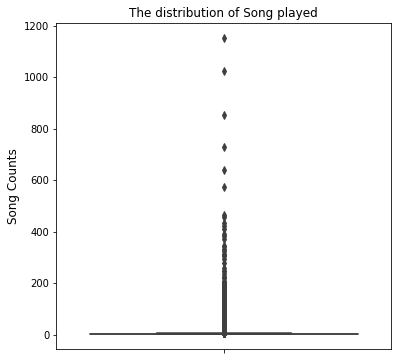

In [77]:
plt.figure(figsize=(6,6))
base_color = sb.color_palette()[0]
sb.boxplot(data = dfsong, y = 'song', color = base_color)
plt.title('The distribution of Song played', fontsize=12)
plt.ylabel('Song Counts', fontsize=12)

Text(0, 0.5, 'Song Length')

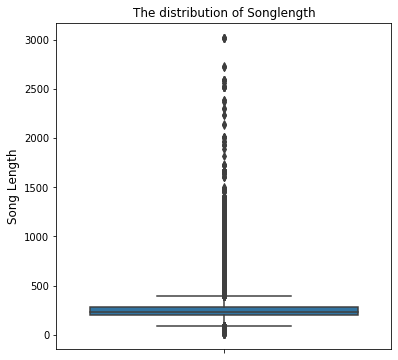

In [78]:
plt.figure(figsize=(6,6))
base_color = sb.color_palette()[0]
sb.boxplot(data = dfs, y = 'length', color = base_color)
plt.title('The distribution of Songlength', fontsize=12)
plt.ylabel('Song Length', fontsize=12)

So there is some of the song's length that has more than 3000 secs.

#### TIme (Monthly, Hourly, Weekdays) 

In [79]:
df3.head()

,artist,gender,itemInSession,length,level,page,song,status,userId,act_time,...,act_year_month,act_hour,act_weekday,act_weekday_abbr,OS,spe_OS,states,churn,downgrade,end_level
0,Martha Tilston,M,50,277.89016,paid,NextSong,Rockpools,200,30,2018-10-01 07:01:57,...,2018-10,7,Monday,Mon,Windows,Windows 7,CA,0,0,paid
1,Five Iron Frenzy,M,79,236.09424,free,NextSong,Canada,200,9,2018-10-01 07:03:00,...,2018-10,7,Monday,Mon,Windows,Windows 7,MA-NH,0,0,paid
2,Adam Lambert,M,51,282.82730,paid,NextSong,Time For Miracles,200,30,2018-10-01 07:06:34,...,2018-10,7,Monday,Mon,Windows,Windows 7,CA,0,0,paid
3,Enigma,M,80,262.71302,free,NextSong,Knocking On Forbidden Doors,200,9,2018-10-01 07:06:56,...,2018-10,7,Monday,Mon,Windows,Windows 7,MA-NH,0,0,paid
4,Daft Punk,M,52,223.60771,paid,NextSong,Harder Better Faster Stronger,200,30,2018-10-01 07:11:16,...,2018-10,7,Monday,Mon,Windows,Windows 7,CA,0,0,paid


In [80]:
df3['act_year_month'].value_counts()

2018-10    143251
2018-11    133440
2018-12      1463
Name: act_year_month, dtype: int64

In [81]:
df3['act_date'].value_counts()

2018-11-02    7929
2018-10-11    6466
2018-10-30    6382
2018-11-16    6252
2018-10-17    6167
              ... 
2018-10-01    2696
2018-10-28    2514
2018-11-18    2465
2018-12-01    1462
2018-12-03       1
Name: act_date, Length: 63, dtype: int64

So we have the period activities of 2 month's worth here with the last month for december only 1 day

In [82]:
def cateplot(dataframe, column_name, xlbl, ylbl, titl, height, width, rotate, align):
    base_color = sb.color_palette()[0]
    g = sb.catplot(data=dataframe, x=column_name, kind='count', color = base_color)
    g.set_axis_labels(xlbl, ylbl)
    g.fig.suptitle(titl, y=1.03, fontsize=14)
    for ax in g.axes.ravel():
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')
    g.fig.set_figheight(height)
    g.fig.set_figwidth(width)
    g.set_xticklabels(rotation=rotate, horizontalalignment=align)

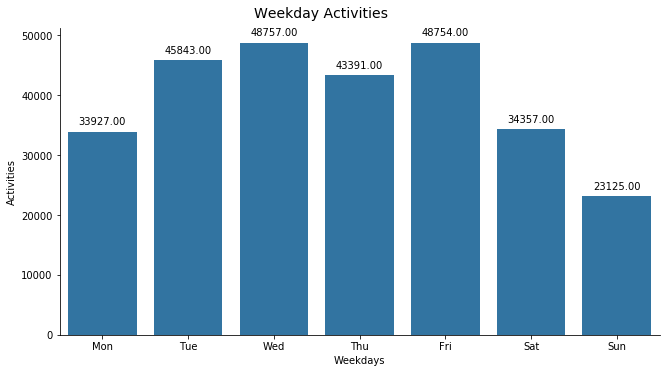

In [83]:
cateplot(df3, 'act_weekday_abbr', 'Weekdays', 'Activities', 'Weekday Activities', 5, 10, 0, 'center')

So we also have the most crowded days are both wednesday and friday while the least crowded days is sudays 

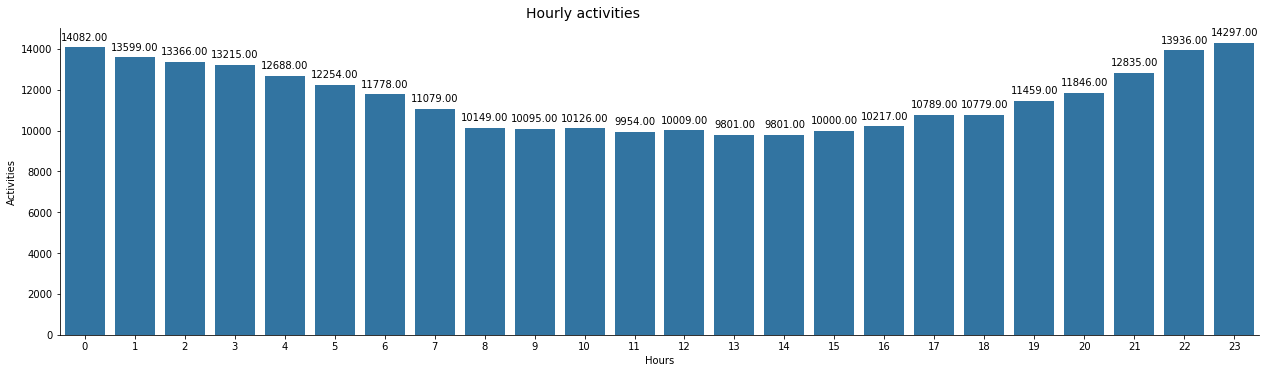

In [84]:
cateplot(df3, 'act_hour', 'Hours', 'Activities', 'Hourly activities', 5, 20, 0, 'center')

The most crowded hours are at around midnight while the least crowded are working hours from 8am -5pm 

#### Operating System

In [85]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278154 entries, 0 to 286499
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   artist            228108 non-null  object        
 1   gender            278154 non-null  object        
 2   itemInSession     278154 non-null  int64         
 3   length            228108 non-null  float64       
 4   level             278154 non-null  object        
 5   page              278154 non-null  object        
 6   song              228108 non-null  object        
 7   status            278154 non-null  int64         
 8   userId            278154 non-null  object        
 9   act_time          278154 non-null  datetime64[ns]
 10  regis_time        278154 non-null  datetime64[ns]
 11  act_date          278154 non-null  object        
 12  act_year_month    278154 non-null  object        
 13  act_hour          278154 non-null  int64         
 14  act_

In [86]:
df3['OS'].value_counts()

Windows    143871
Mac        125322
Linux        8961
Name: OS, dtype: int64

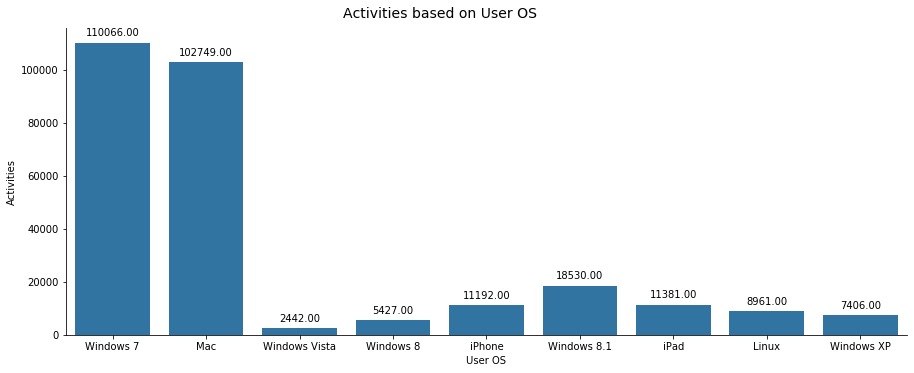

In [87]:
cateplot(df3, 'spe_OS', 'User OS', 'Activities', 'Activities based on User OS', 5, 15, 0, 'center')

With this we can know that most of the user is either windows or Mac users. 

#### Location/State

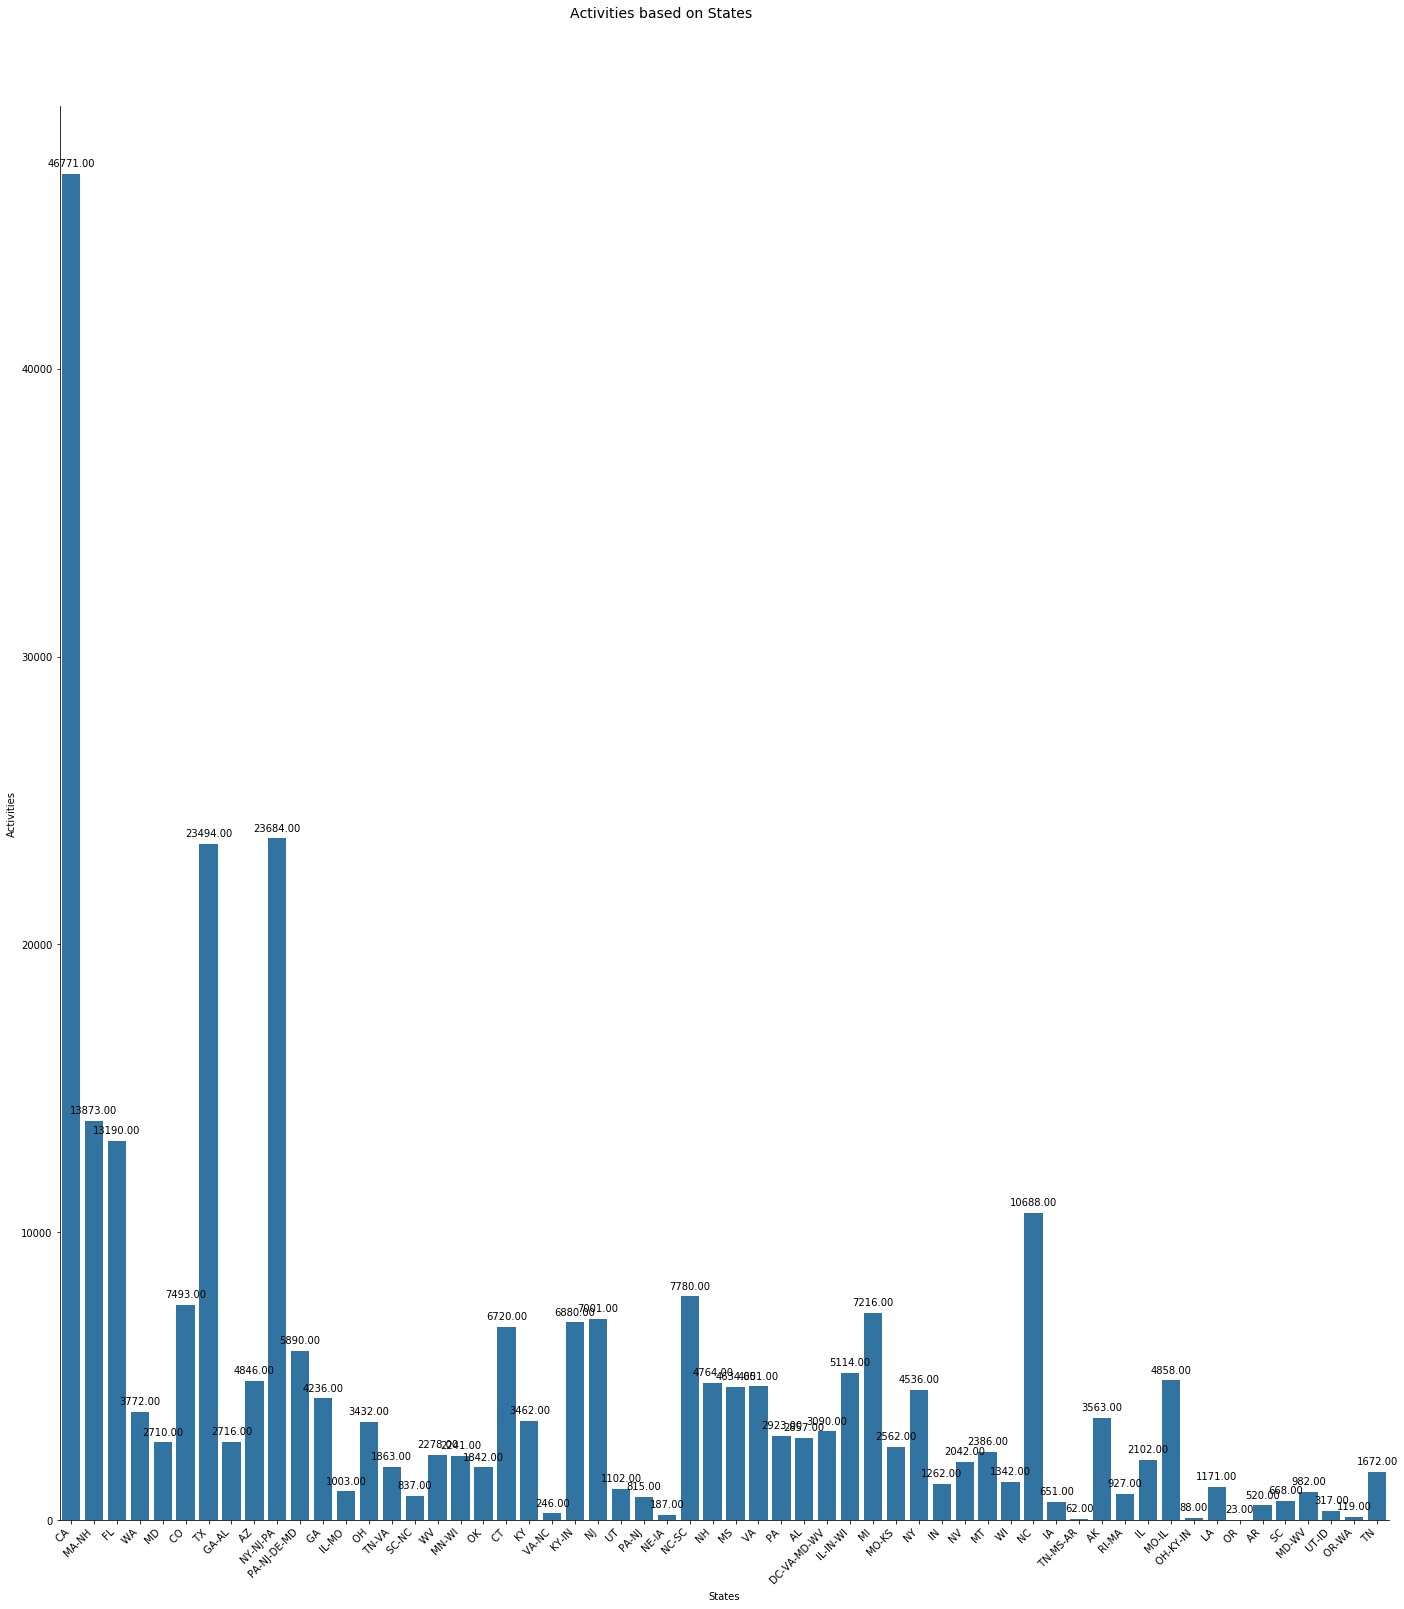

In [88]:
cateplot(df3, 'states', 'States', 'Activities', 'Activities based on States', 23, 23, 45, 'right')

The state where most users reside are CA, TX, NY-NJ-PA and NC state 

#### Page Activities 

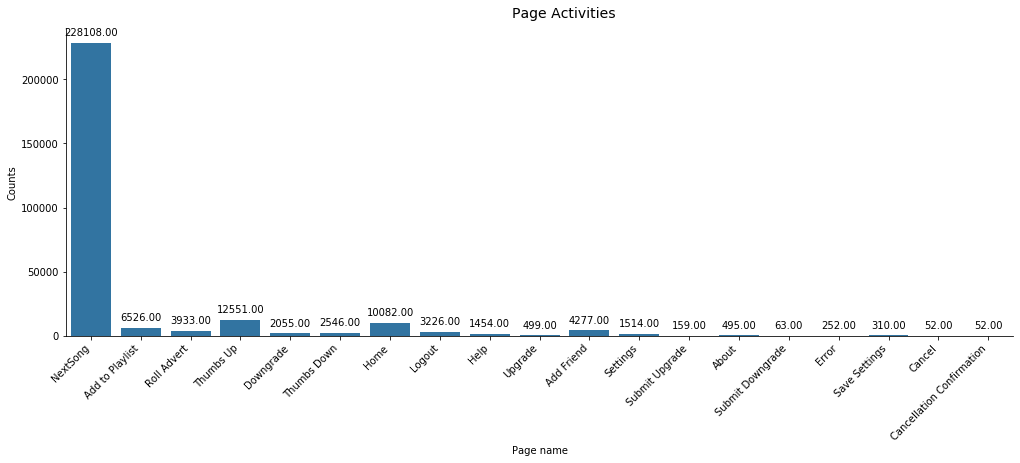

In [89]:
cateplot(df3, 'page', 'Page name', 'Counts', 'Page Activities', 5, 20, 45, 'right')

In [90]:
dfu = df3.drop_duplicates(subset='userId')
dfu

,artist,gender,itemInSession,length,level,page,song,status,userId,act_time,...,act_year_month,act_hour,act_weekday,act_weekday_abbr,OS,spe_OS,states,churn,downgrade,end_level
0,Martha Tilston,M,50,277.89016,paid,NextSong,Rockpools,200,30,2018-10-01 07:01:57,...,2018-10,7,Monday,Mon,Windows,Windows 7,CA,0,0,paid
1,Five Iron Frenzy,M,79,236.09424,free,NextSong,Canada,200,9,2018-10-01 07:03:00,...,2018-10,7,Monday,Mon,Windows,Windows 7,MA-NH,0,0,paid
17,Tokyo Police Club,F,0,166.11220,free,NextSong,Citizens Of Tomorrow,200,74,2018-10-01 07:27:48,...,2018-10,7,Monday,Mon,Mac,Mac,FL,0,0,paid
22,Modjo,F,0,250.93179,paid,NextSong,What I Mean,200,54,2018-10-01 07:32:10,...,2018-10,7,Monday,Mon,Windows,Windows 7,WA,1,0,paid
74,Dwight Yoakam,M,0,239.30730,free,NextSong,You're The One,200,4,2018-10-01 08:17:30,...,2018-10,8,Monday,Mon,Windows,Windows Vista,MD,0,0,paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255127,B.o.B,M,0,269.63546,free,NextSong,Nothin' On You [feat. Bruno Mars] (Album Version),200,300018,2018-10-11 13:03:25,...,2018-10,13,Thursday,Thu,Mac,Mac,IL-IN-WI,0,0,paid
256598,Cabas,M,0,235.41506,free,NextSong,Hoy Que Te Vas,200,300006,2018-10-12 20:42:43,...,2018-10,20,Friday,Fri,Mac,Mac,CT,0,0,paid
256706,Weird Al Yankovic,M,0,202.47465,free,NextSong,"Amish Paradise (Parody of ""Gangsta's Paradise""...",200,300003,2018-10-12 21:54:57,...,2018-10,21,Friday,Fri,Windows,Windows 7,OR-WA,0,0,free
259062,Kings Of Leon,F,0,231.26159,free,NextSong,Use Somebody,200,300004,2018-10-17 02:27:54,...,2018-10,2,Wednesday,Wed,Windows,Windows 7,CA,0,1,free


#### Gender, Churn, Downgrade and End_level

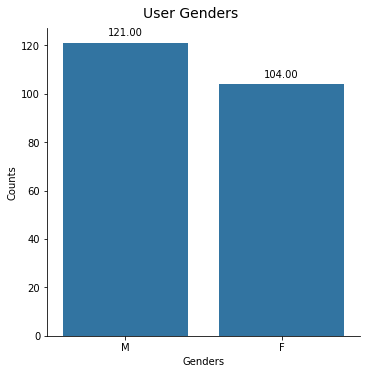

In [91]:
cateplot(dfu, 'gender', 'Genders', 'Counts', 'User Genders', 5, 5, 0, 'center')

The gender is almost the same counts

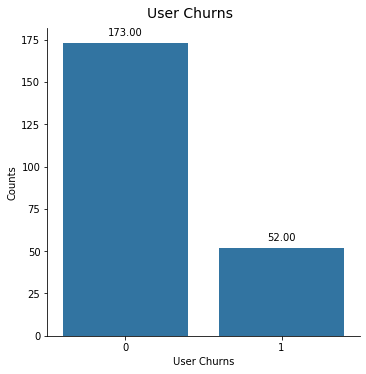

In [92]:
cateplot(dfu, 'churn', 'User Churns', 'Counts', 'User Churns', 5, 5, 0, 'center')

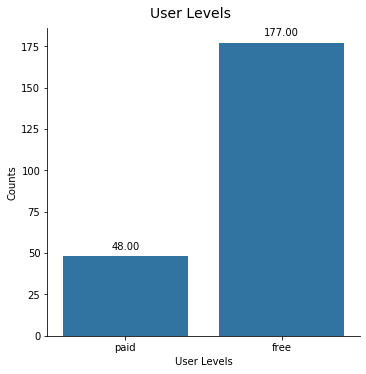

In [93]:
cateplot(dfu, 'level', 'User Levels', 'Counts', 'User Levels', 5, 5, 0, 'center')

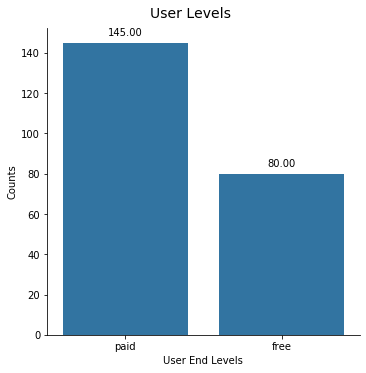

In [94]:
cateplot(dfu, 'end_level', 'User End Levels', 'Counts', 'User Levels', 5, 5, 0, 'center')

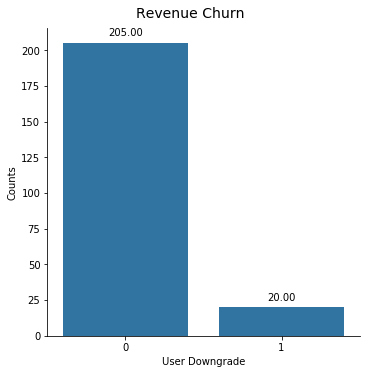

In [95]:
cateplot(dfu, 'downgrade', 'User Downgrade', 'Counts', 'Revenue Churn', 5, 5, 0, 'center')

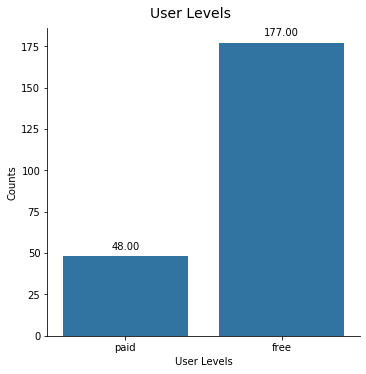

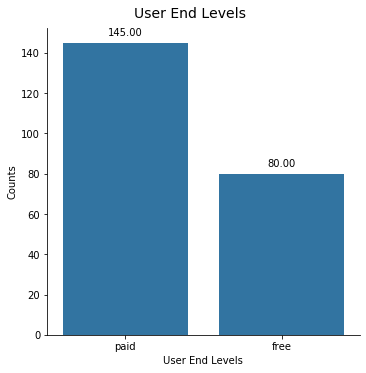

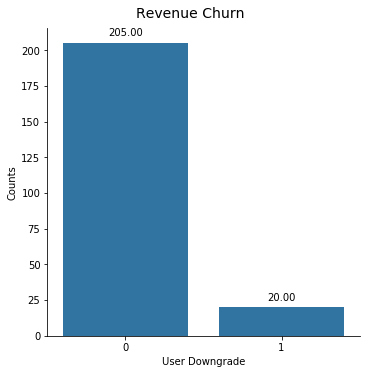

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, sharey=True)
fig.add_subplot(131)
cateplot(dfu, 'level', 'User Levels', 'Counts', 'User Levels', 5, 5, 0, 'center')
plt.yticks(rotation=360) 
fig.add_subplot(132)
cateplot(dfu, 'end_level', 'User End Levels', 'Counts', 'User End Levels', 5, 5, 0, 'center')
plt.yticks(rotation=360)
fig.add_subplot(133)
cateplot(dfu, 'downgrade', 'User Downgrade', 'Counts', 'Revenue Churn', 5, 5, 0, 'center')
plt.yticks(rotation=360)
plt.close(1)

We can see that the number of the paid user increased at the end of period and there is a total of 20 user from 225 users that choose to downgrade from the specified 2 months 

## Bivariate & Multivariate 
### Churns

In [97]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278154 entries, 0 to 286499
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   artist            228108 non-null  object        
 1   gender            278154 non-null  object        
 2   itemInSession     278154 non-null  int64         
 3   length            228108 non-null  float64       
 4   level             278154 non-null  object        
 5   page              278154 non-null  object        
 6   song              228108 non-null  object        
 7   status            278154 non-null  int64         
 8   userId            278154 non-null  object        
 9   act_time          278154 non-null  datetime64[ns]
 10  regis_time        278154 non-null  datetime64[ns]
 11  act_date          278154 non-null  object        
 12  act_year_month    278154 non-null  object        
 13  act_hour          278154 non-null  int64         
 14  act_

In [98]:
def barplot(height, width, xcol, ycol, hues, dataframe, titl, xtitl, ytitl, htitle, rotate, align): 
    plt.figure(figsize=(height, width))
    g = sb.barplot(x=xcol, y=ycol, hue=hues, data=dataframe)
    plt.title(titl, fontsize=22, y=1.015)
    plt.xlabel(xtitl, fontsize=16,labelpad=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=rotate, horizontalalignment=align)
    plt.ylabel(ytitl, fontsize=16,labelpad=16)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2.,
            p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
            textcoords = 'offset points')
    leg = g.legend(prop={'size':12})
    leg.set_title(htitle, prop={'size':12})
    g= plt.gca()

In [99]:
def barplot1(xcol, ycol, hues, dataframe, titl, xtitl, ytitl, htitle, rotate, align): 
    g = sb.barplot(x=xcol, y=ycol, hue=hues, data=dataframe)
    plt.title(titl, fontsize=22, y=1.015)
    plt.xlabel(xtitl, fontsize=16,labelpad=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=rotate, horizontalalignment=align)
    plt.ylabel(ytitl, fontsize=16,labelpad=16)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2.,
            p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
            textcoords = 'offset points')
    leg = g.legend(prop={'size':12})
    leg.set_title(htitle, prop={'size':12})
    g= plt.gca()

In [100]:
dfs = df3[df3['page'] == 'NextSong']
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228108 entries, 0 to 286499
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   artist            228108 non-null  object        
 1   gender            228108 non-null  object        
 2   itemInSession     228108 non-null  int64         
 3   length            228108 non-null  float64       
 4   level             228108 non-null  object        
 5   page              228108 non-null  object        
 6   song              228108 non-null  object        
 7   status            228108 non-null  int64         
 8   userId            228108 non-null  object        
 9   act_time          228108 non-null  datetime64[ns]
 10  regis_time        228108 non-null  datetime64[ns]
 11  act_date          228108 non-null  object        
 12  act_year_month    228108 non-null  object        
 13  act_hour          228108 non-null  int64         
 14  act_

In [101]:
song_length = dfs.groupby(["churn", "userId"]).agg({'length' : 'sum'}).rename(columns={'length':'count'}).reset_index()
song_length['count'] = song_length['count']/3600 
song_length

,churn,userId,count
0,0,10,46.351770
1,0,100,186.910516
2,0,100002,13.766644
3,0,100004,64.300108
4,0,100008,53.165777
...,...,...,...
220,1,54,197.595811
221,1,58,117.121274
222,1,70,103.094706
223,1,73,26.177875


Text(0, 0.5, 'Listened Song Length in Hours')

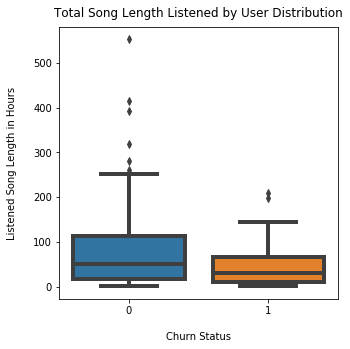

In [102]:
plt.figure(figsize=(5,5))
ax = sb.boxplot(x='churn', y='count', linewidth=4, data= song_length)
plt.title('Total Song Length Listened by User Distribution', y=1.015)
plt.xlabel('Churn Status', labelpad=16)
plt.ylabel('Listened Song Length in Hours', labelpad=16)

In [103]:
lifetime_churn = df3.groupby(["churn", "userId", "regis_time"]).agg({'act_time' : 'max'}).reset_index()
ticks_per_day = 1000 * 60 * 60 * 24
lifetime_churn['user_lifetime'] = (lifetime_churn.act_time - lifetime_churn.regis_time)/pd.Timedelta(hours=1)/24
lifetime_churn

,churn,userId,regis_time,act_time,user_lifetime
0,0,10,2018-09-29 01:31:35,2018-11-19 19:49:48,51.762650
1,0,100,2018-09-27 00:17:35,2018-11-30 21:15:49,64.873773
2,0,100002,2018-06-25 20:51:29,2018-12-03 08:11:16,160.472072
3,0,100004,2018-06-09 23:04:02,2018-11-29 09:37:45,172.440081
4,0,100008,2018-09-20 17:44:31,2018-11-27 23:13:39,68.228565
...,...,...,...,...,...
220,1,54,2018-07-25 08:37:42,2018-11-13 02:40:08,110.751690
221,1,58,2018-09-26 17:12:31,2018-10-22 22:43:26,26.229803
222,1,70,2018-06-22 11:51:43,2018-11-15 05:34:27,145.738009
223,1,73,2018-09-05 06:15:43,2018-10-25 00:33:07,49.762083


Text(0, 0.5, 'User Lifetime')

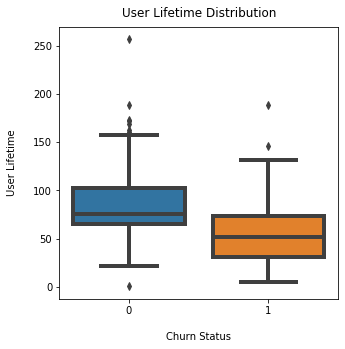

In [104]:
plt.figure(figsize=(5,5))
ax = sb.boxplot(x='churn', y='user_lifetime', linewidth=4, data= lifetime_churn)
plt.title('User Lifetime Distribution', y=1.015)
plt.xlabel('Churn Status', labelpad=16)
plt.ylabel('User Lifetime', labelpad=16)

Text(0, 0.5, 'User Lifetime in Days')

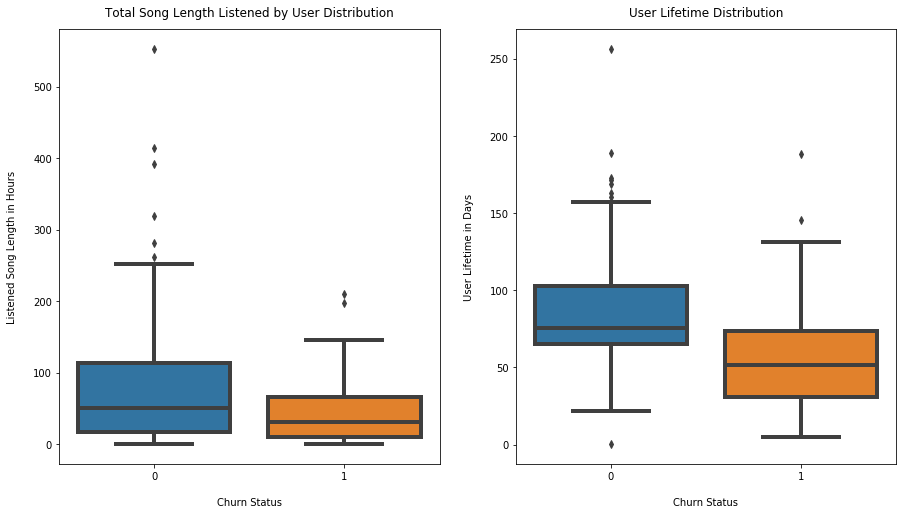

In [105]:
plt.figure(figsize=(15,8))
plt.subplot(121)
ax = sb.boxplot(x='churn', y='count', linewidth=4, data= song_length)
plt.title('Total Song Length Listened by User Distribution', y=1.015)
plt.xlabel('Churn Status', labelpad=16)
plt.ylabel('Listened Song Length in Hours', labelpad=16)
plt.subplot(122) 
ax = sb.boxplot(x='churn', y='user_lifetime', linewidth=4, data= lifetime_churn)
plt.title('User Lifetime Distribution', y=1.015)
plt.xlabel('Churn Status', labelpad=16)
plt.ylabel('User Lifetime in Days', labelpad=16)

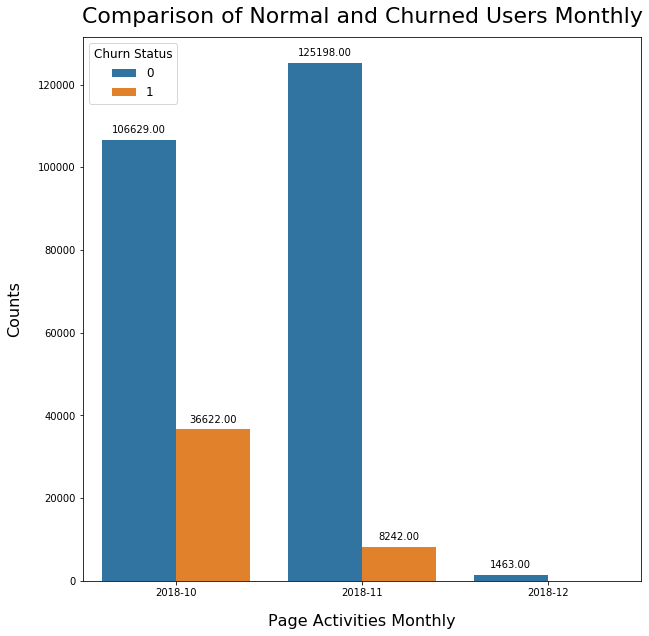

In [106]:
month_churn = df3.groupby(["act_year_month", "churn"]).size().reset_index().rename(columns={0: 'counts'})
barplot(10,10, 'act_year_month', 'counts', 'churn', month_churn, 'Comparison of Normal and Churned Users Monthly', 'Page Activities Monthly', 'Counts', 'Churn Status', 0, 'center')

We know that the churned user activites is mostly at October so it must means that there is many user churned that month 

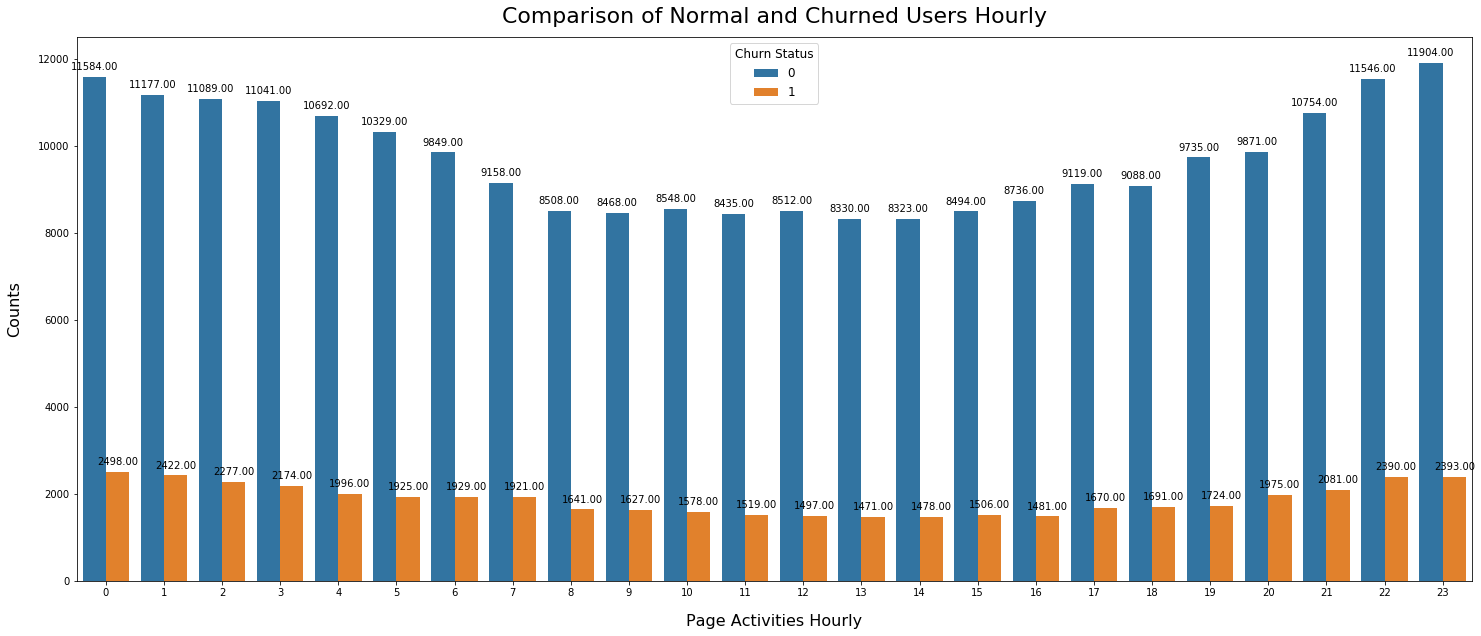

In [107]:
hour_churn = df3.groupby(["act_hour", "churn"]).size().reset_index().rename(columns={0: 'counts'})
barplot(25,10, 'act_hour', 'counts', 'churn', hour_churn, 'Comparison of Normal and Churned Users Hourly', 'Page Activities Hourly', 'Counts', 'Churn Status', 0, 'center')

So we can see that both the churned users and stayed users have the same pattern as the overall total activities of the users. 

In [108]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278154 entries, 0 to 286499
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   artist            228108 non-null  object        
 1   gender            278154 non-null  object        
 2   itemInSession     278154 non-null  int64         
 3   length            228108 non-null  float64       
 4   level             278154 non-null  object        
 5   page              278154 non-null  object        
 6   song              228108 non-null  object        
 7   status            278154 non-null  int64         
 8   userId            278154 non-null  object        
 9   act_time          278154 non-null  datetime64[ns]
 10  regis_time        278154 non-null  datetime64[ns]
 11  act_date          278154 non-null  object        
 12  act_year_month    278154 non-null  object        
 13  act_hour          278154 non-null  int64         
 14  act_

In [109]:
day_churn = df3.groupby(["act_weekday_abbr", "churn"]).size().reset_index().rename(columns={0: 'counts'})
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_churn['order'] = day_churn["act_weekday_abbr"]
day_churn.loc[day_churn.order == 'Mon', 'order'] = 1
day_churn.loc[day_churn.order == 'Tue', 'order'] = 2
day_churn.loc[day_churn.order == 'Wed', 'order'] = 3
day_churn.loc[day_churn.order == 'Thu', 'order'] = 4
day_churn.loc[day_churn.order == 'Fri', 'order'] = 5
day_churn.loc[day_churn.order == 'Sat', 'order'] = 6
day_churn.loc[day_churn.order == 'Sun', 'order'] = 7
day_churn = day_churn.sort_values('order')
day_churn

,act_weekday_abbr,churn,counts,order
2,Mon,0,28885,1
3,Mon,1,5042,1
10,Tue,0,38642,2
11,Tue,1,7201,2
12,Wed,0,40731,3
13,Wed,1,8026,3
8,Thu,0,35746,4
9,Thu,1,7645,4
0,Fri,0,40750,5
1,Fri,1,8004,5


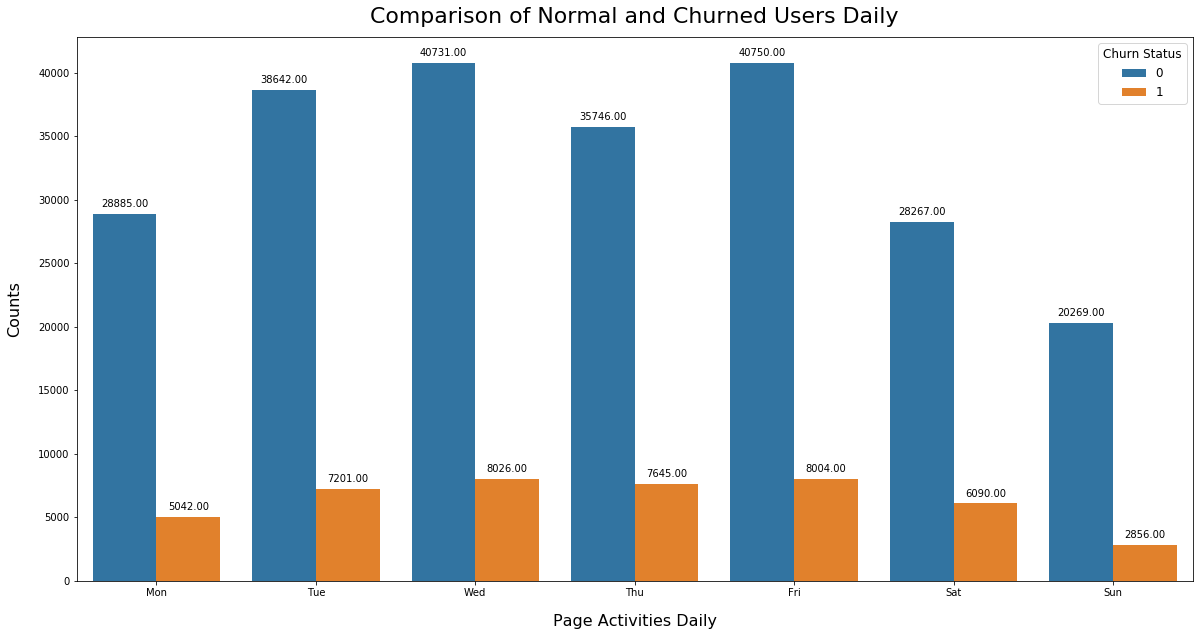

In [110]:
barplot(20,10, 'act_weekday_abbr', 'counts', 'churn', day_churn, 'Comparison of Normal and Churned Users Daily', 'Page Activities Daily', 'Counts', 'Churn Status', 0, 'center')

So there is slight differences for the churned and stayed users where the 2 days with the least activities for churned users are both Sundays and Mondays while for the stayed users, the least days with activity are Weekends

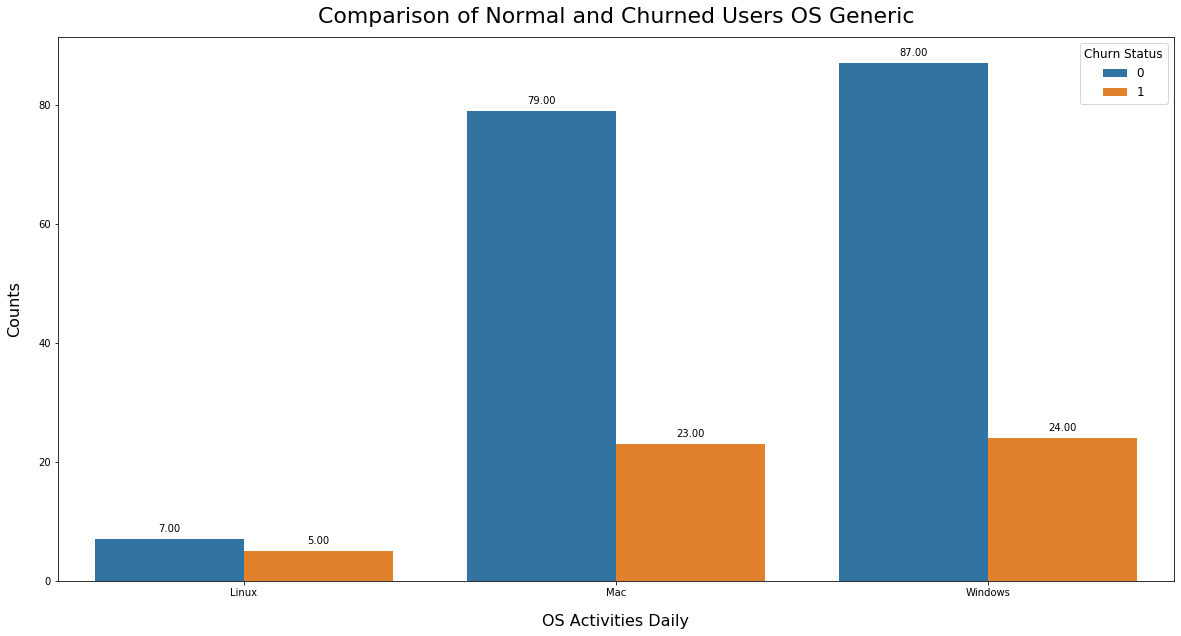

In [111]:
OS_churn = dfu.groupby(["OS", "churn"]).size().reset_index().rename(columns={0: 'counts'})
barplot(20,10, 'OS', 'counts', 'churn', OS_churn, 'Comparison of Normal and Churned Users OS Generic', 'OS Activities Daily', 'Counts', 'Churn Status', 0, 'center')

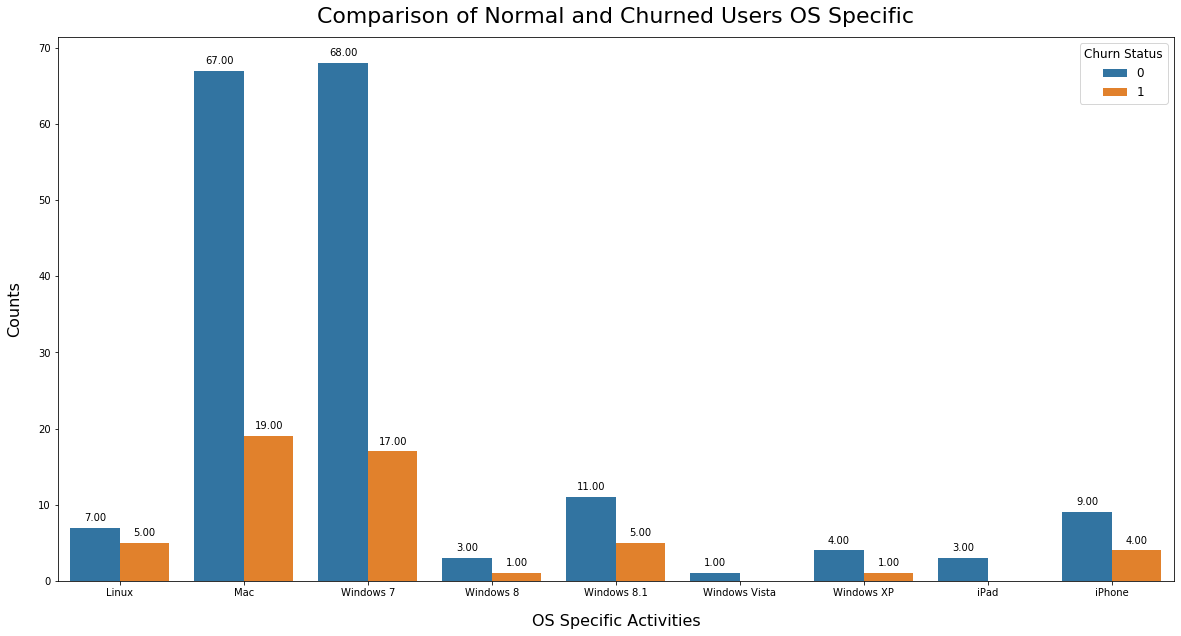

In [112]:
spe_churn = dfu.groupby(["spe_OS", "churn"]).size().reset_index().rename(columns={0: 'counts'})
barplot(20,10, 'spe_OS', 'counts', 'churn', spe_churn, 'Comparison of Normal and Churned Users OS Specific', 'OS Specific Activities', 'Counts', 'Churn Status', 0, 'center')

For the OS we can see that there are many windows user in both churned users and stayed users while in the specific OS we can see some more details of their OS

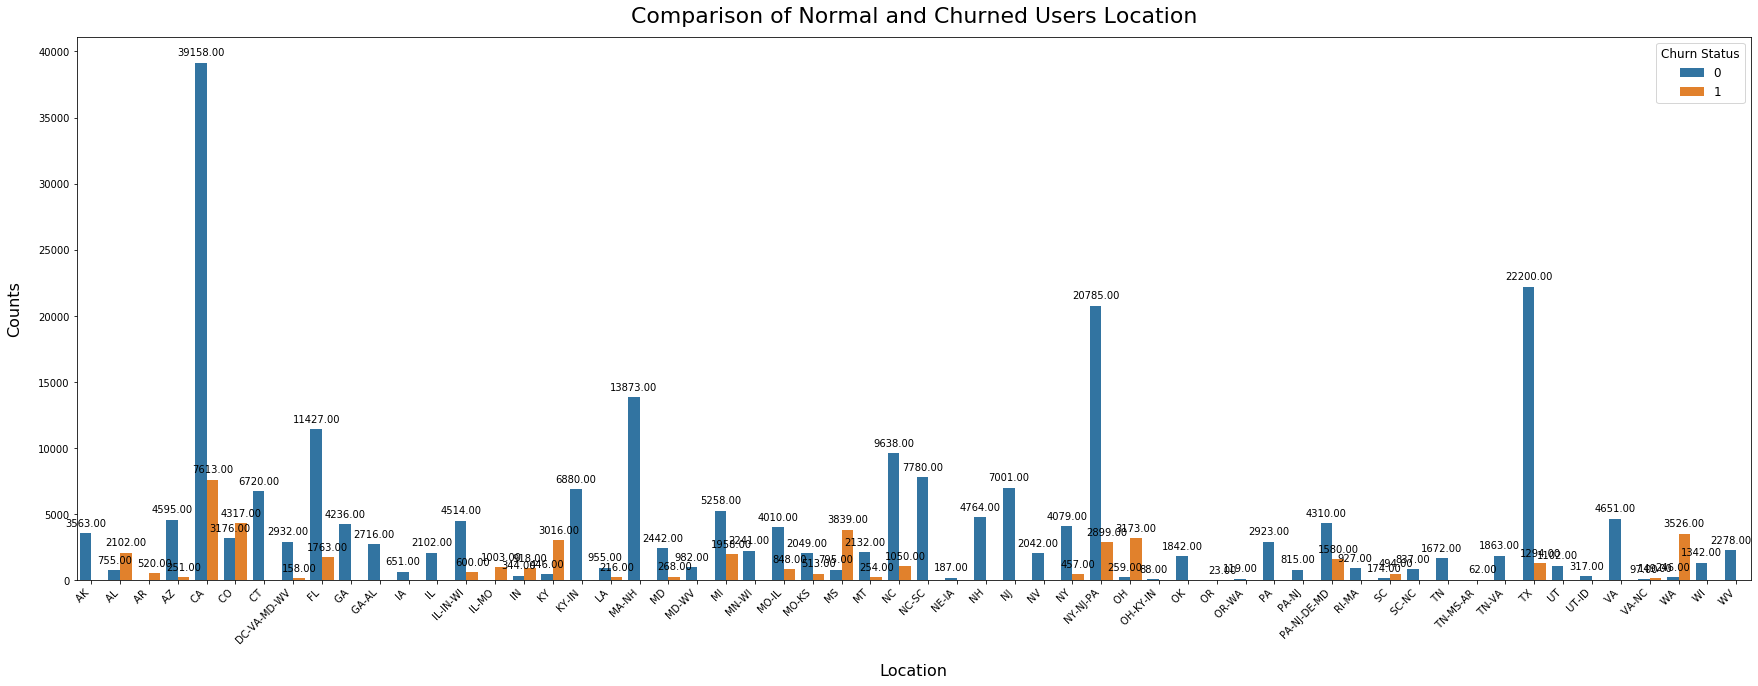

In [113]:
loc_churn = df3.groupby(["states", "churn"]).size().reset_index().rename(columns={0:'counts'})
barplot(30,10, 'states', 'counts', 'churn', loc_churn, 'Comparison of Normal and Churned Users Location', 'Location', 'Counts', 'Churn Status', 45, 'right')

There are some specific states where most stayed users reside CA, TX, NY-NJ-PA, MA-NH, FL while churned users reside at CA, CO, KY, MS, CA and WA.  

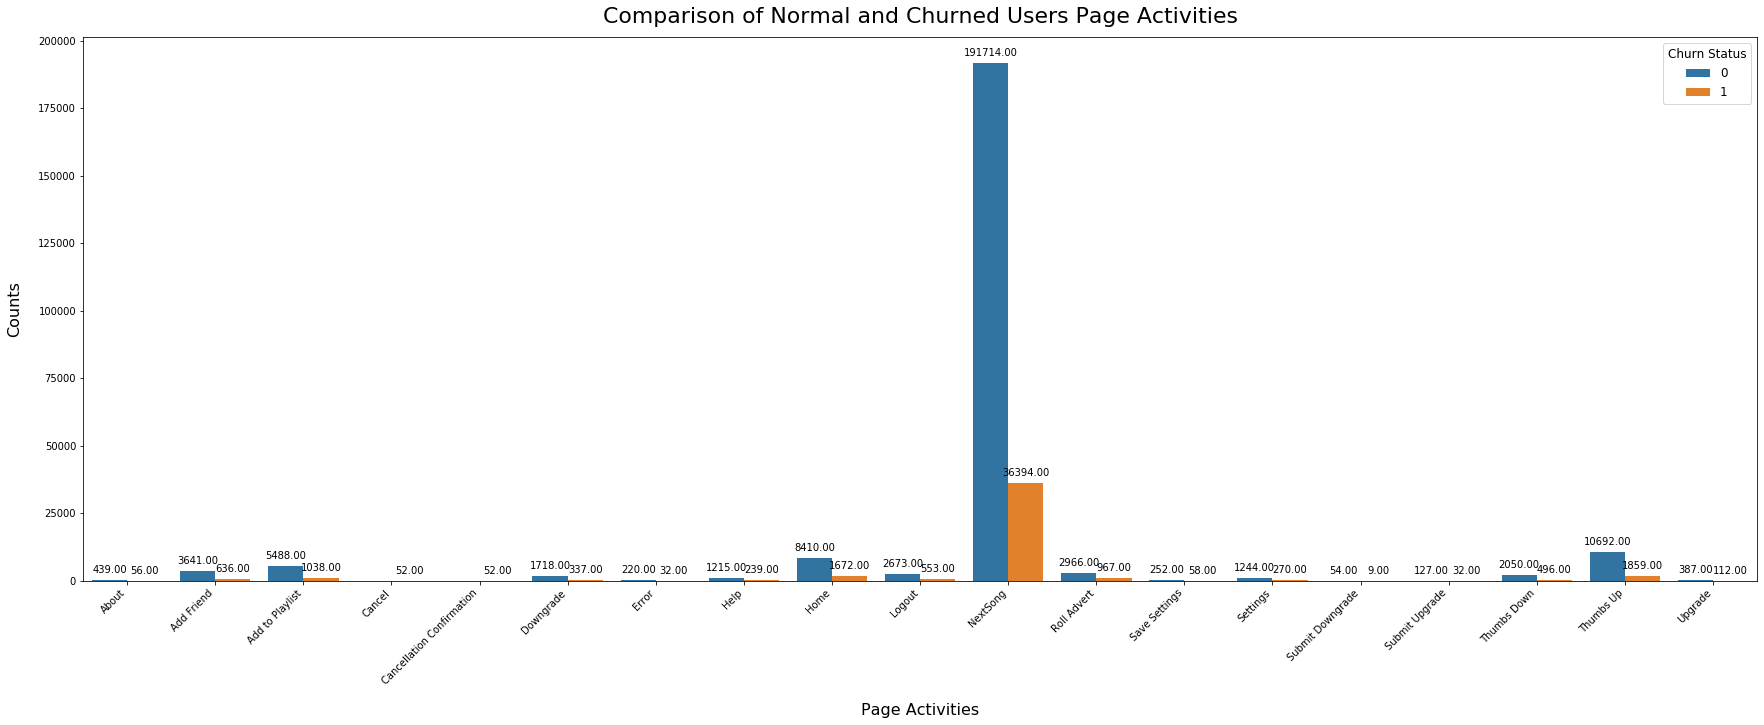

In [114]:
page_churn = df3.groupby(["page", "churn"]).size().reset_index().rename(columns={0:'counts'})
barplot(30,10, 'page', 'counts', 'churn', page_churn, 'Comparison of Normal and Churned Users Page Activities', 'Page Activities', 'Counts', 'Churn Status', 45, 'right')

We can see that their activities is centered around NextSong and Thumbs up page

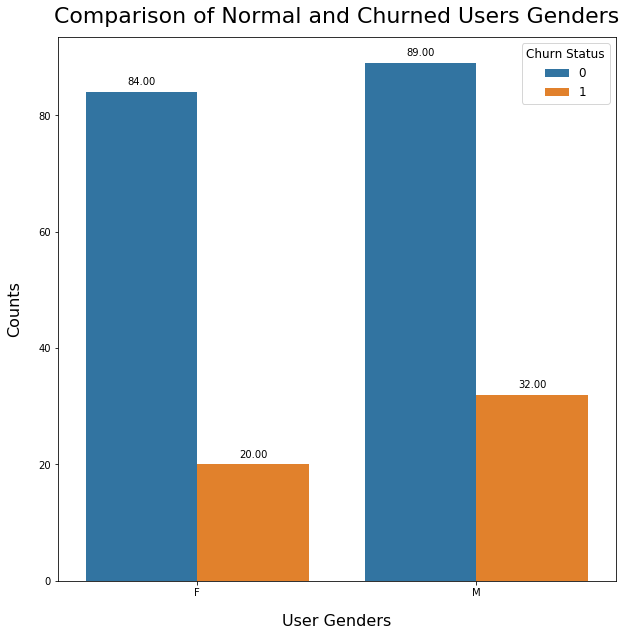

In [115]:
gender_churn = dfu.groupby(["gender", "churn"]).size().reset_index().rename(columns={0:'counts'})
barplot(10,10, 'gender', 'counts', 'churn', gender_churn, 'Comparison of Normal and Churned Users Genders', 'User Genders', 'Counts', 'Churn Status', 0, 'center')

So in total the male user churned more than female user. 

In [116]:
level_churn = dfu.groupby(["level", "churn"]).size().reset_index().rename(columns={0:'counts'})
end_level_churn = dfu.groupby(["end_level", "churn"]).size().reset_index().rename(columns={0:'counts'})

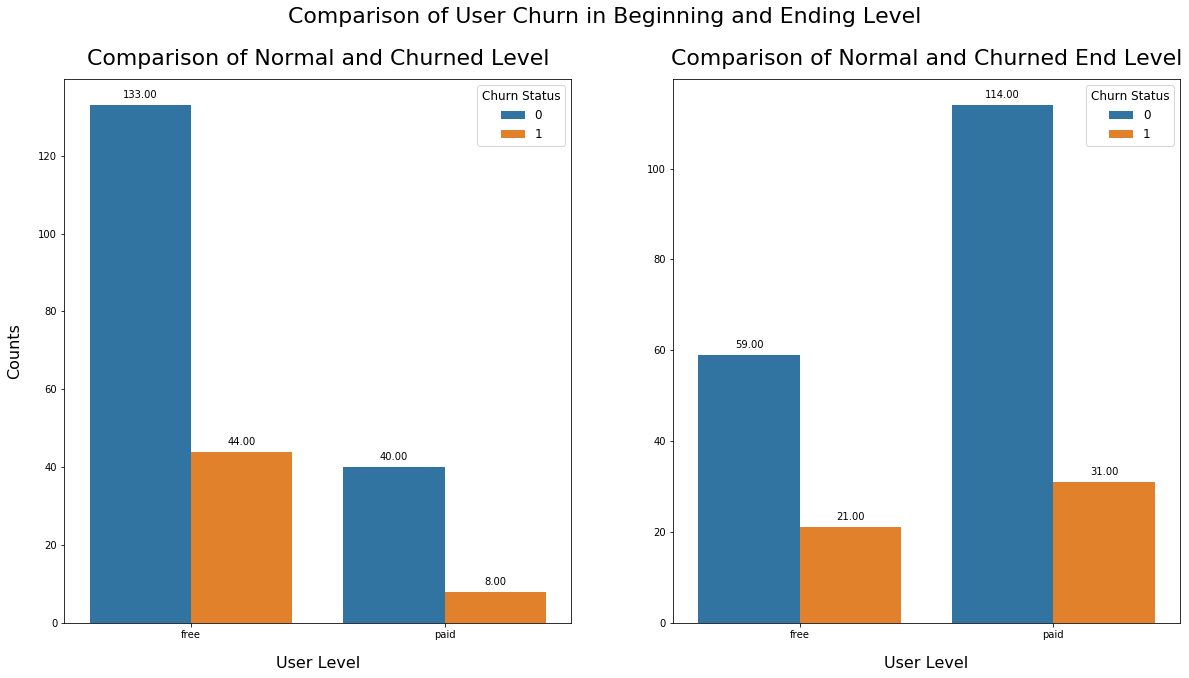

In [117]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.suptitle('Comparison of User Churn in Beginning and Ending Level', fontsize=22)
barplot1('level', 'counts', 'churn', level_churn, 'Comparison of Normal and Churned Level', 'User Level', 'Counts', 'Churn Status', 0, 'center')
plt.subplot(122)
barplot1('end_level', 'counts', 'churn', end_level_churn, 'Comparison of Normal and Churned End Level', 'User Level', '', 'Churn Status', 0, 'center')

So there are more paid users that churned and possibly downgrade when we compared the differences of the beginning and ending churned users level; however, this might be because of there are many users that upgrade their accounts from free to paid. 

### Downgrades 

In [118]:
song_lengthd = dfs.groupby(["downgrade", "userId"]).agg({'length' : 'sum'}).rename(columns={'length':'count'}).reset_index()
song_lengthd['count'] = song_lengthd['count']/3600 
song_lengthd 

,downgrade,userId,count
0,0,10,46.351770
1,0,100,186.910516
2,0,100001,9.742706
3,0,100002,13.766644
4,0,100003,3.418450
...,...,...,...
220,1,300004,14.140985
221,1,35,112.940126
222,1,61,112.914669
223,1,92,414.303691


Text(0, 0.5, 'Listened Song Length in hours')

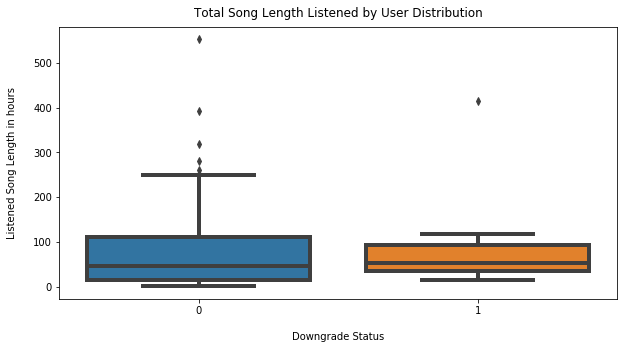

In [119]:
plt.figure(figsize=(10,5))
ax = sb.boxplot(x='downgrade', y='count', linewidth=4, data= song_lengthd)
plt.title('Total Song Length Listened by User Distribution', y=1.015)
plt.xlabel('Downgrade Status', labelpad=16)
plt.ylabel('Listened Song Length in hours', labelpad=16)

In [120]:
lifetime_down = df3.groupby(["downgrade", "userId", "regis_time"]).agg({'act_time' : 'max'}).reset_index()
lifetime_down['user_lifetime'] = (lifetime_down.act_time - lifetime_down.regis_time)/pd.Timedelta(hours=1)/24
lifetime_down

,downgrade,userId,regis_time,act_time,user_lifetime
0,0,10,2018-09-29 01:31:35,2018-11-19 19:49:48,51.762650
1,0,100,2018-09-27 00:17:35,2018-11-30 21:15:49,64.873773
2,0,100001,2018-08-19 04:24:26,2018-10-02 23:36:45,44.800220
3,0,100002,2018-06-25 20:51:29,2018-12-03 08:11:16,160.472072
4,0,100003,2018-09-19 05:22:24,2018-10-11 23:19:41,22.748113
...,...,...,...,...,...
220,1,300004,2018-08-17 20:44:05,2018-11-15 05:41:25,89.373148
221,1,35,2018-09-16 06:16:52,2018-11-30 17:24:09,75.463391
222,1,61,2018-09-17 19:48:58,2018-11-29 00:54:04,72.211875
223,1,92,2018-09-08 17:52:52,2018-12-01 06:34:25,83.528854


Text(0, 0.5, 'User Lifetime in days')

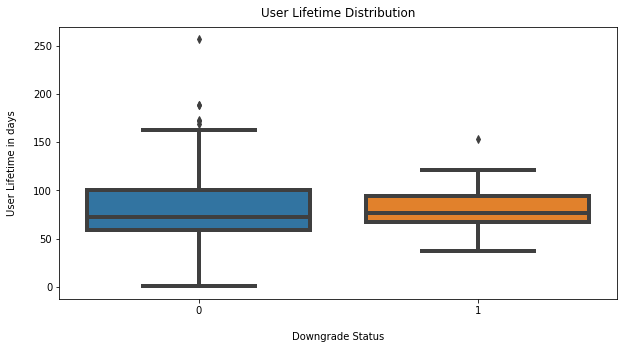

In [121]:
plt.figure(figsize=(10,5))
ax = sb.boxplot(x='downgrade', y='user_lifetime', linewidth=4, data= lifetime_down)
plt.title('User Lifetime Distribution', y=1.015)
plt.xlabel('Downgrade Status', labelpad=16)
plt.ylabel('User Lifetime in days', labelpad=16)

Text(0, 0.5, 'User Lifetime in days')

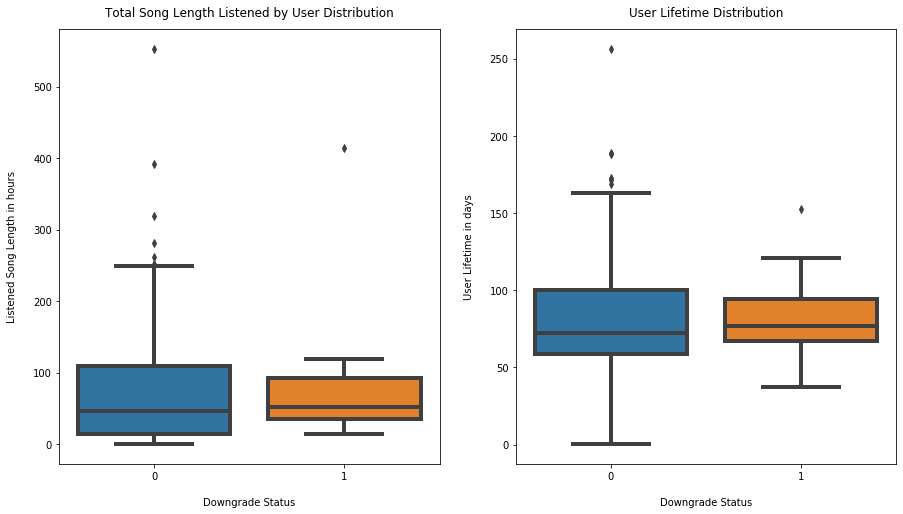

In [122]:
plt.figure(figsize=(15,8))
plt.subplot(121)
ax = sb.boxplot(x='downgrade', y='count', linewidth=4, data= song_lengthd)
plt.title('Total Song Length Listened by User Distribution', y=1.015)
plt.xlabel('Downgrade Status', labelpad=16)
plt.ylabel('Listened Song Length in hours', labelpad=16)
plt.subplot(122) 
ax = sb.boxplot(x='downgrade', y='user_lifetime', linewidth=4, data= lifetime_down)
plt.title('User Lifetime Distribution', y=1.015)
plt.xlabel('Downgrade Status', labelpad=16)
plt.ylabel('User Lifetime in days', labelpad=16)

In [123]:
month_down = df3.groupby(["act_year_month", "downgrade"]).size().reset_index().rename(columns={0: 'counts'})
month_down

,act_year_month,downgrade,counts
0,2018-10,0,126693
1,2018-10,1,16558
2,2018-11,0,121651
3,2018-11,1,11789
4,2018-12,0,1318
5,2018-12,1,145


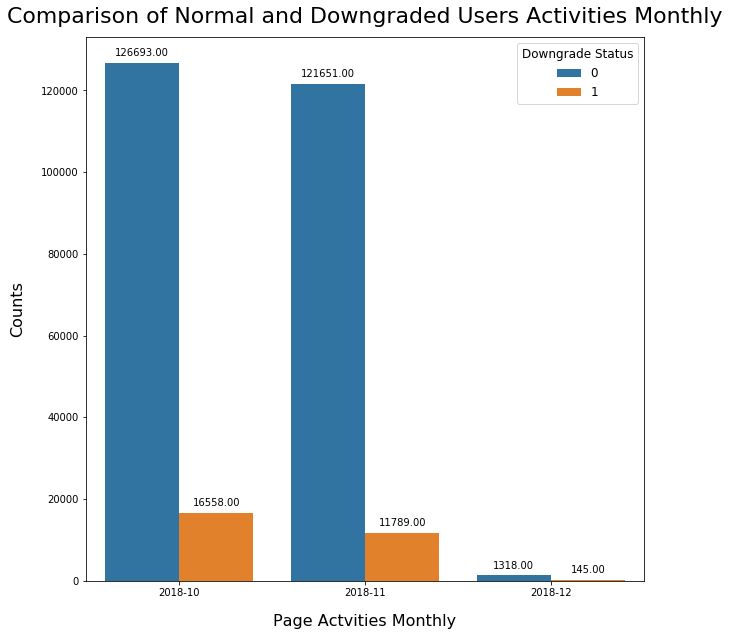

In [124]:
month_down = df3.groupby(["act_year_month", "downgrade"]).size().reset_index().rename(columns={0: 'counts'})
barplot(10,10, 'act_year_month', 'counts', 'downgrade', month_down, 'Comparison of Normal and Downgraded Users Activities Monthly', 'Page Actvities Monthly', 'Counts', 'Downgrade Status', 0, 'center')

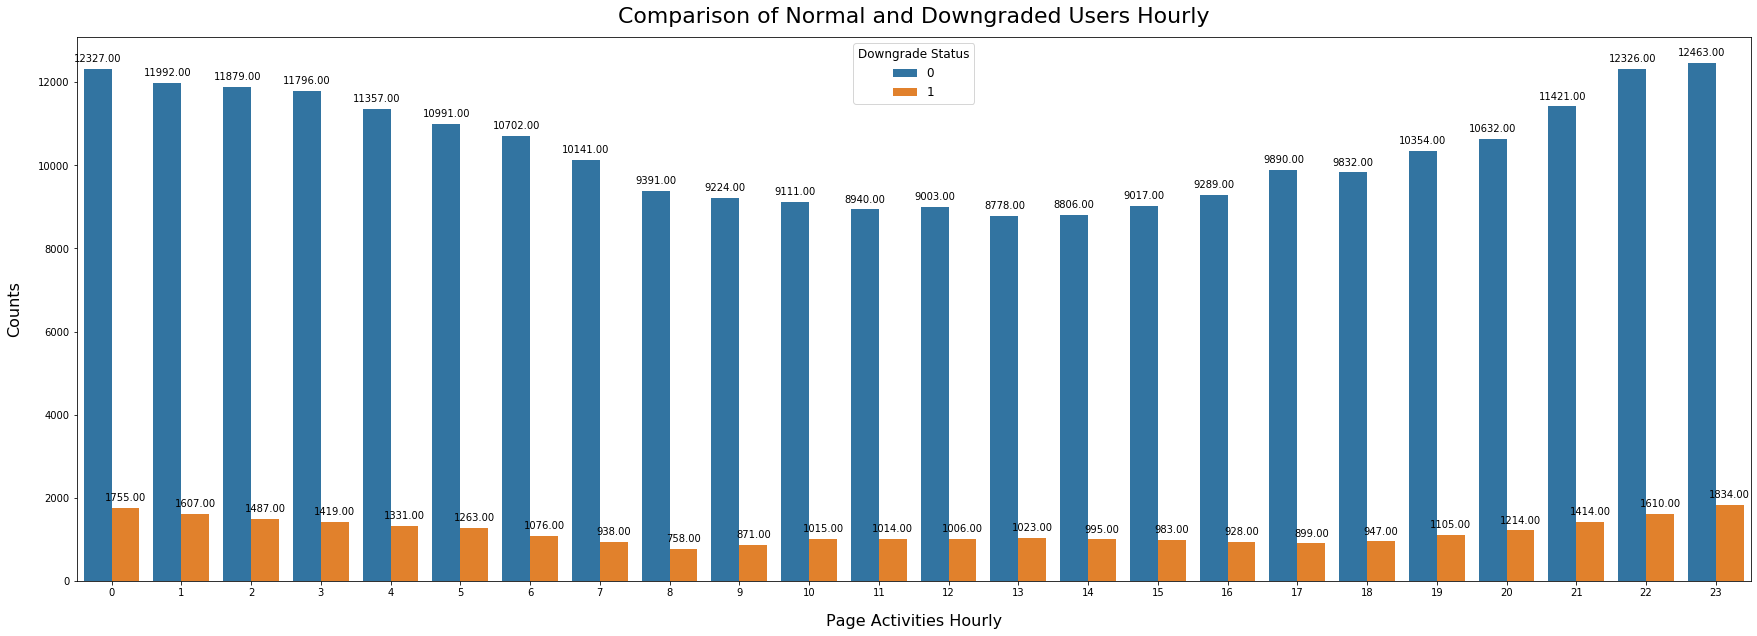

In [125]:
hour_down = df3.groupby(["act_hour", "downgrade"]).size().reset_index().rename(columns={0: 'counts'})
barplot(30,10, 'act_hour', 'counts', 'downgrade', hour_down, 'Comparison of Normal and Downgraded Users Hourly', 'Page Activities Hourly', 'Counts', 'Downgrade Status', 0, 'center')

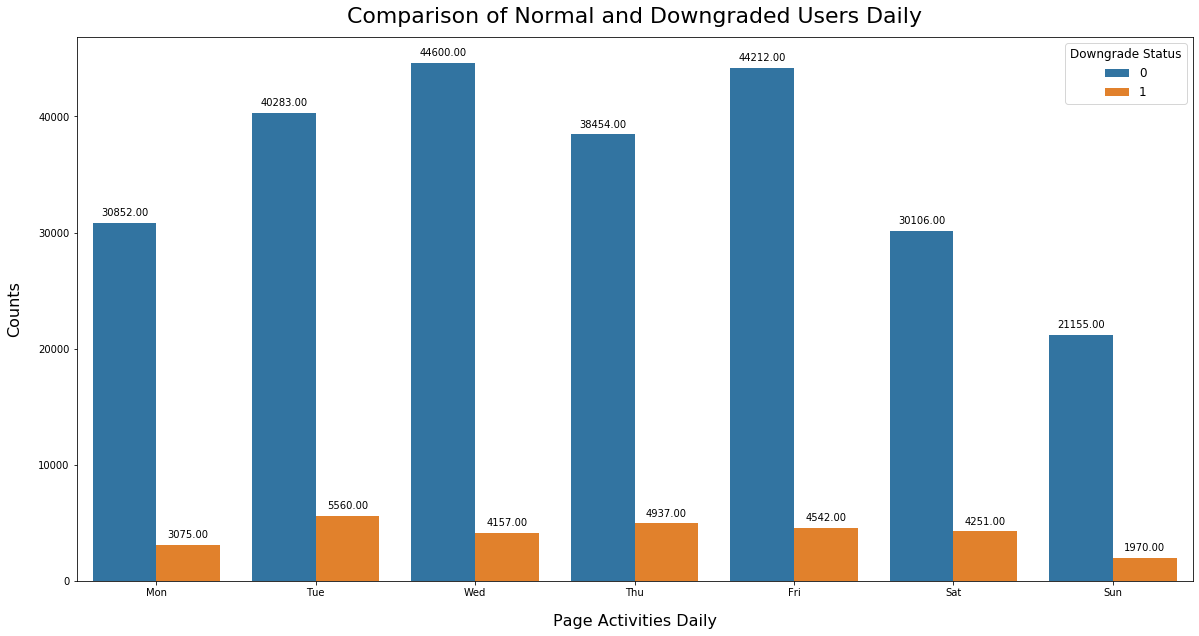

In [126]:
day_down = df3.groupby(["act_weekday_abbr", "downgrade"]).size().reset_index().rename(columns={0: 'counts'})
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_down['order'] = day_down["act_weekday_abbr"]
day_down.loc[day_down.order == 'Mon', 'order'] = 1
day_down.loc[day_down.order == 'Tue', 'order'] = 2
day_down.loc[day_down.order == 'Wed', 'order'] = 3
day_down.loc[day_down.order == 'Thu', 'order'] = 4
day_down.loc[day_down.order == 'Fri', 'order'] = 5
day_down.loc[day_down.order == 'Sat', 'order'] = 6
day_down.loc[day_down.order == 'Sun', 'order'] = 7
day_down = day_down.sort_values('order')
barplot(20,10, 'act_weekday_abbr', 'counts', 'downgrade', day_down, 'Comparison of Normal and Downgraded Users Daily', 'Page Activities Daily', 'Counts', 'Downgrade Status', 0, 'center')

Downgraded users mostly active at Tuesday while the most active stayed users are mostly at Wednesday

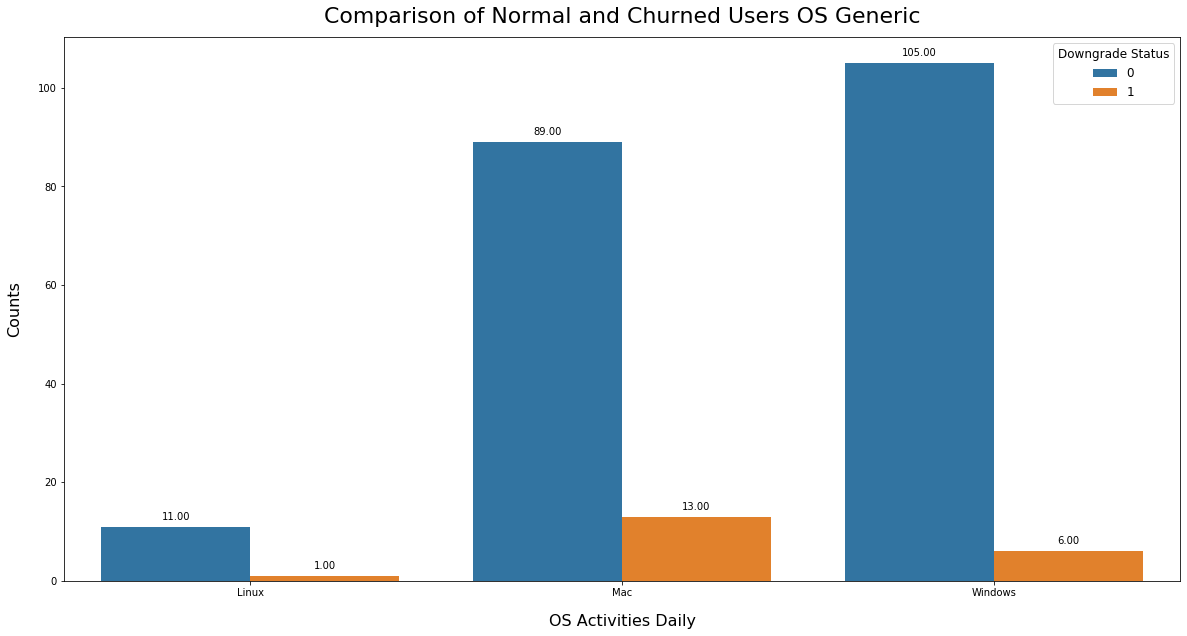

In [127]:
OS_down = dfu.groupby(["OS", "downgrade"]).size().reset_index().rename(columns={0: 'counts'})
barplot(20,10, 'OS', 'counts', 'downgrade', OS_down, 'Comparison of Normal and Churned Users OS Generic', 'OS Activities Daily', 'Counts', 'Downgrade Status', 0, 'center')

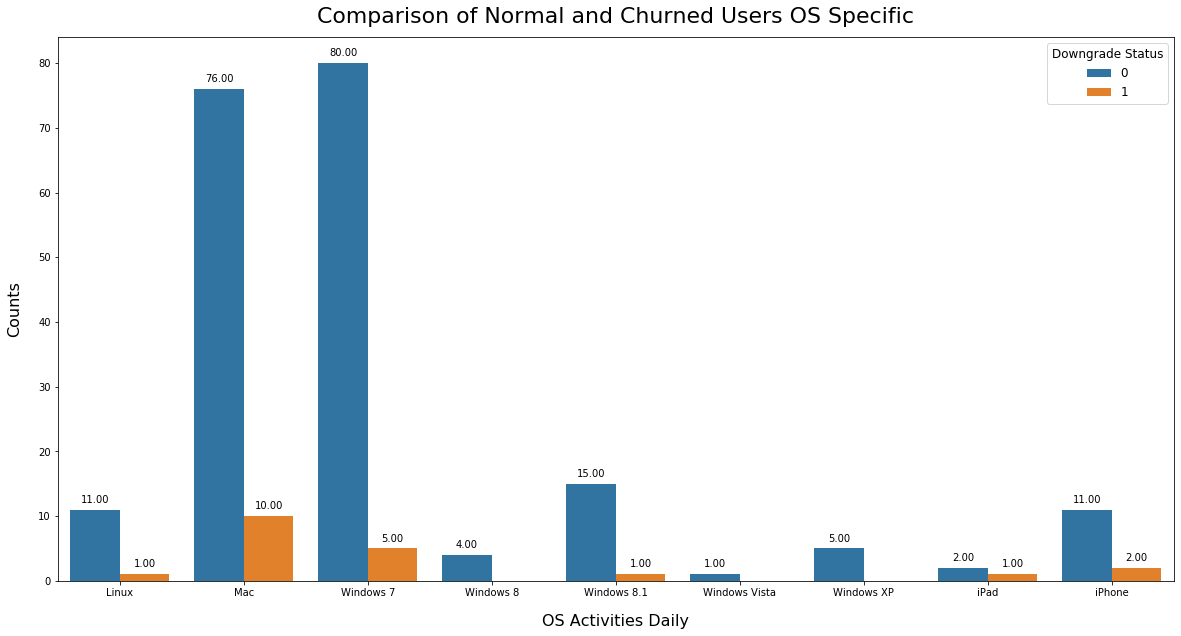

In [128]:
spe_down = dfu.groupby(["spe_OS", "downgrade"]).size().reset_index().rename(columns={0: 'counts'})
barplot(20,10, 'spe_OS', 'counts', 'downgrade', spe_down, 'Comparison of Normal and Churned Users OS Specific', 'OS Activities Daily', 'Counts', 'Downgrade Status', 0, 'center')

SO we knew that many of the users that downgraded comes from Mac OS mosly 

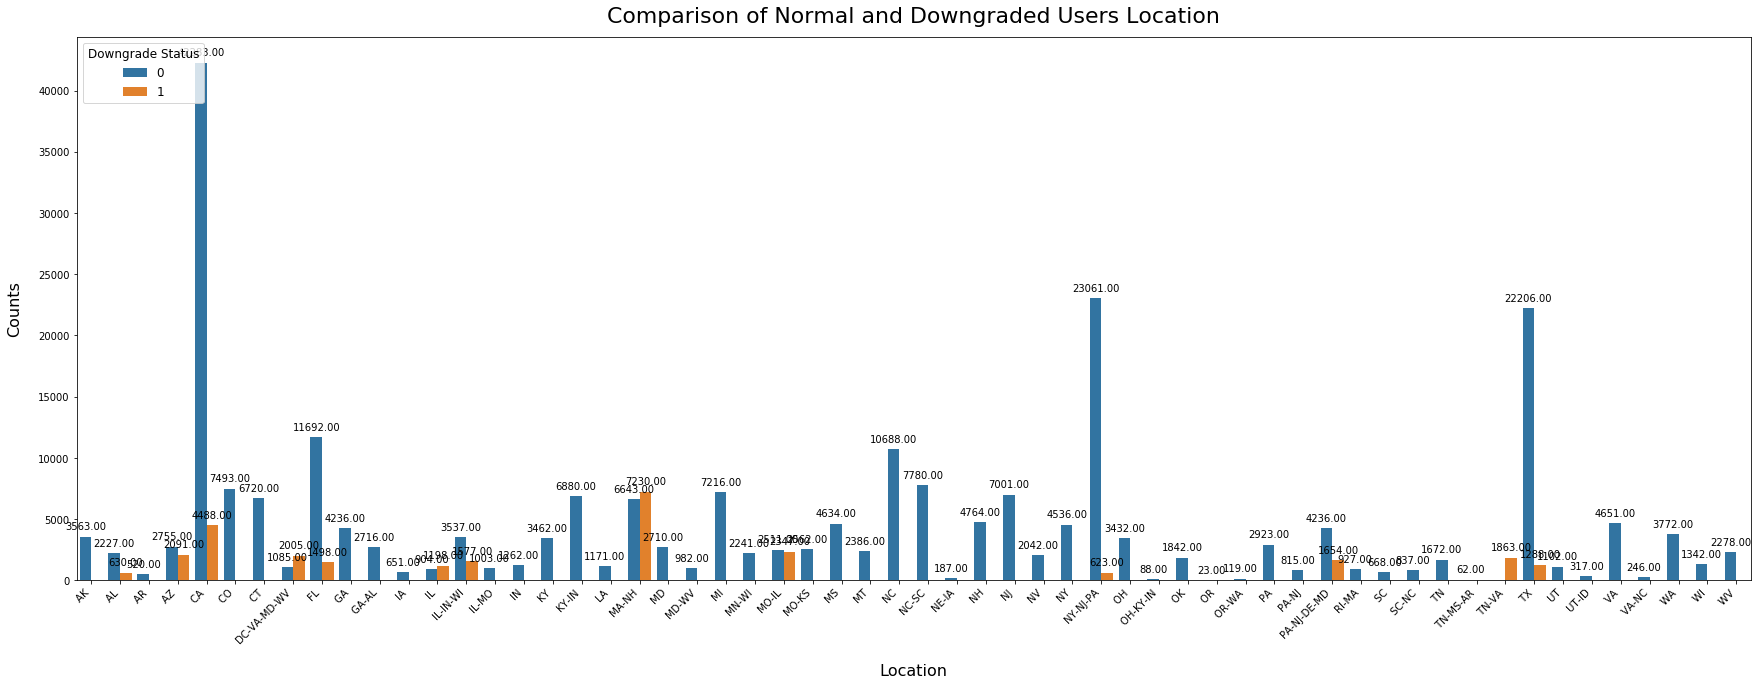

In [129]:
loc_down = df3.groupby(["states", "downgrade"]).size().reset_index().rename(columns={0:'counts'})
barplot(30,10, 'states', 'counts', 'downgrade', loc_down, 'Comparison of Normal and Downgraded Users Location', 'Location', 'Counts', 'Downgrade Status', 45, 'right')

The activities of the downgraded users comes from state of MA-NH and CA 

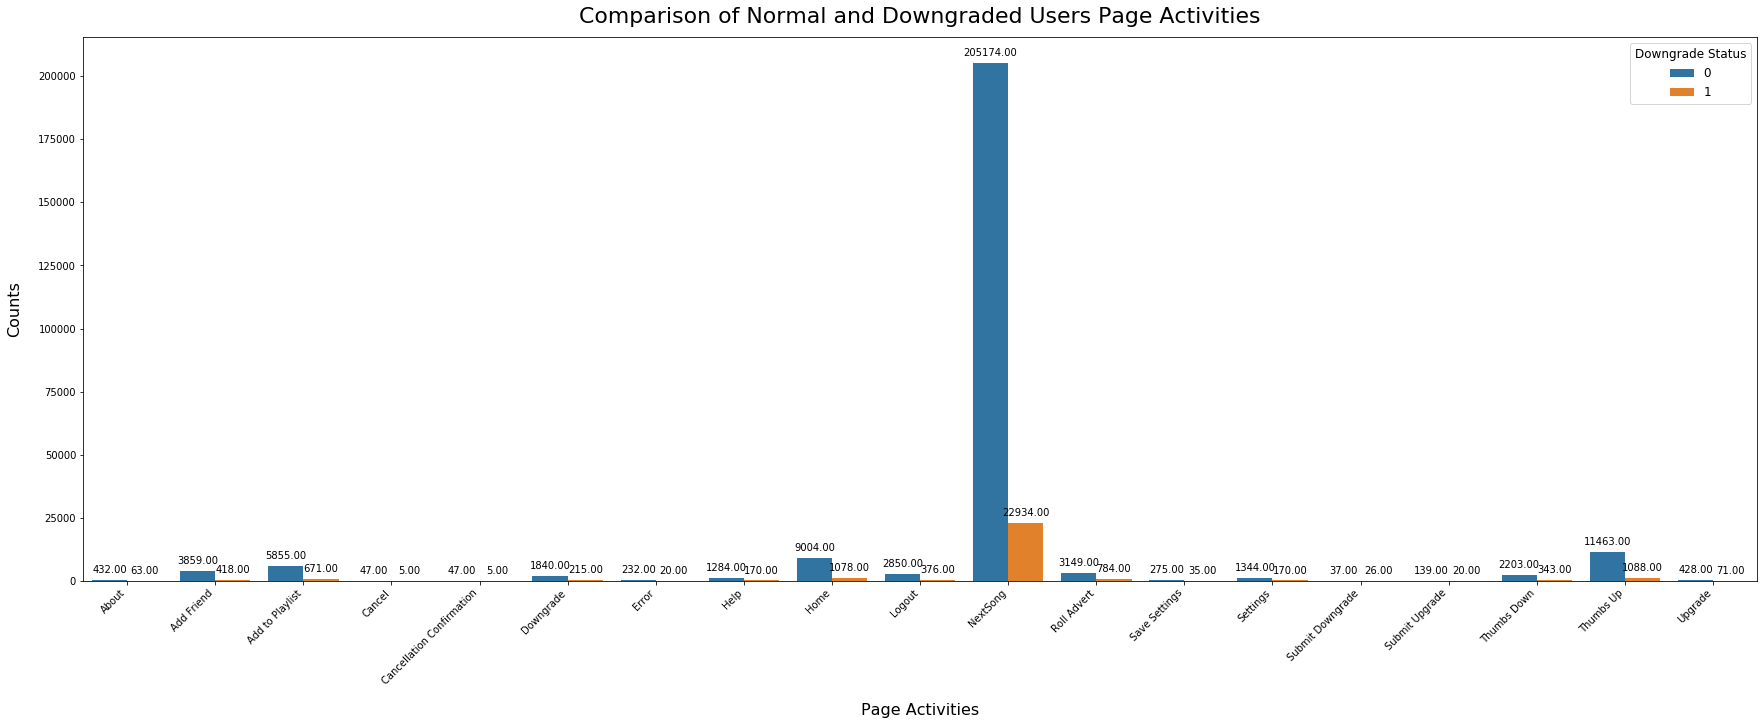

In [130]:
page_down = df3.groupby(["page", "downgrade"]).size().reset_index().rename(columns={0:'counts'})
barplot(30,10, 'page', 'counts', 'downgrade', page_down, 'Comparison of Normal and Downgraded Users Page Activities', 'Page Activities', 'Counts', 'Downgrade Status', 45, 'right')

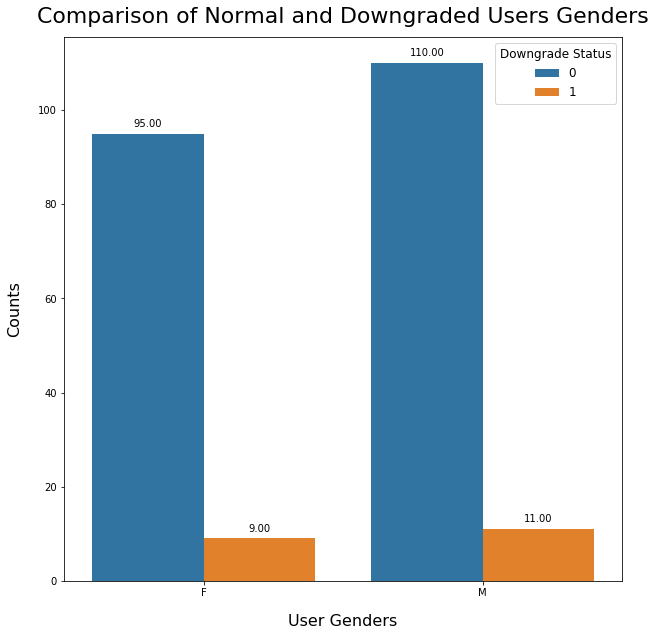

In [131]:
gender_down = dfu.groupby(["gender", "downgrade"]).size().reset_index().rename(columns={0:'counts'})
barplot(10,10, 'gender', 'counts', 'downgrade', gender_down, 'Comparison of Normal and Downgraded Users Genders', 'User Genders', 'Counts', 'Downgrade Status', 0, 'center') 

In [132]:
level_down = dfu.groupby(["level", "downgrade"]).size().reset_index().rename(columns={0:'counts'})
end_level_down = dfu.groupby(["end_level", "downgrade"]).size().reset_index().rename(columns={0:'counts'})

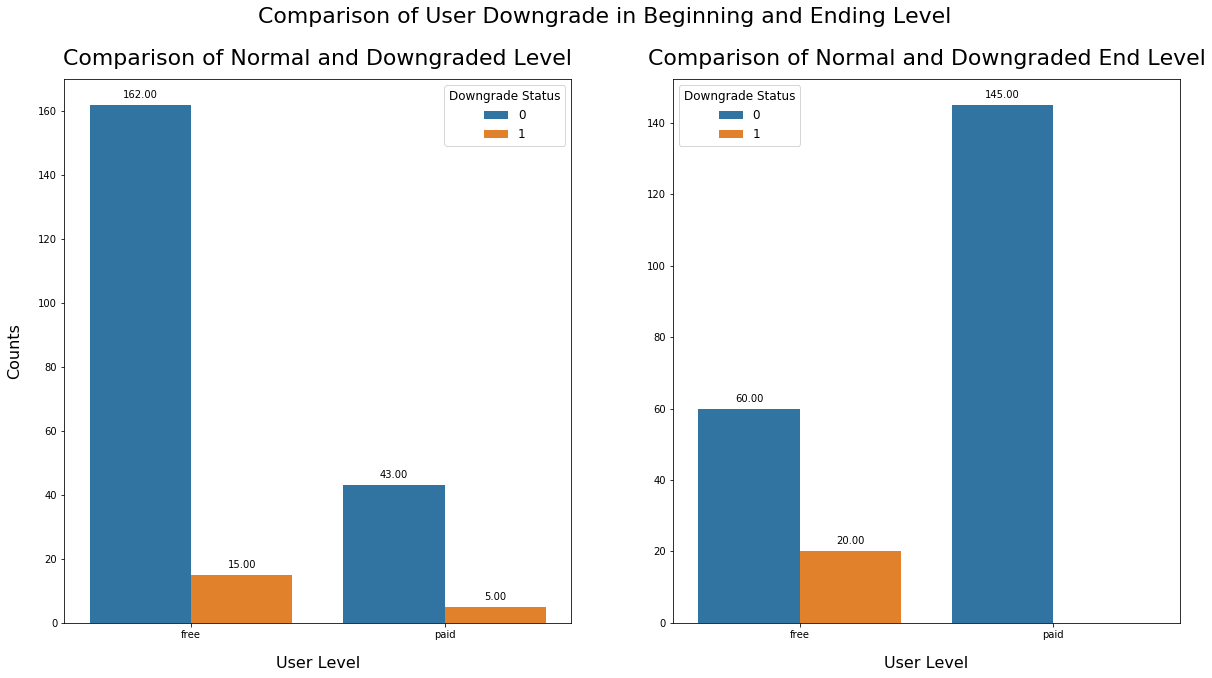

In [133]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.suptitle('Comparison of User Downgrade in Beginning and Ending Level', fontsize=22)
barplot1('level', 'counts', 'downgrade', level_down, 'Comparison of Normal and Downgraded Level', 'User Level', 'Counts', 'Downgrade Status', 0, 'center')
plt.subplot(122)
barplot1('end_level', 'counts', 'downgrade', end_level_down, 'Comparison of Normal and Downgraded End Level', 'User Level', '', 'Downgrade Status', 0, 'center')

So we can conclude that by end_level, there is no one that downgraded while still at paid level in the end. 

In [134]:
churn_down_gender = df3.drop_duplicates(subset='userId').groupby(["downgrade", "churn", "gender"]).size().reset_index().rename(columns={0:'counts'})
churn_down_f = churn_down_gender[churn_down_gender['gender'] == 'F']
churn_down_m = churn_down_gender[churn_down_gender['gender'] == 'M']
churn_down_gender

,downgrade,churn,gender,counts
0,0,0,F,76
1,0,0,M,82
2,0,1,F,19
3,0,1,M,28
4,1,0,F,8
5,1,0,M,7
6,1,1,F,1
7,1,1,M,4


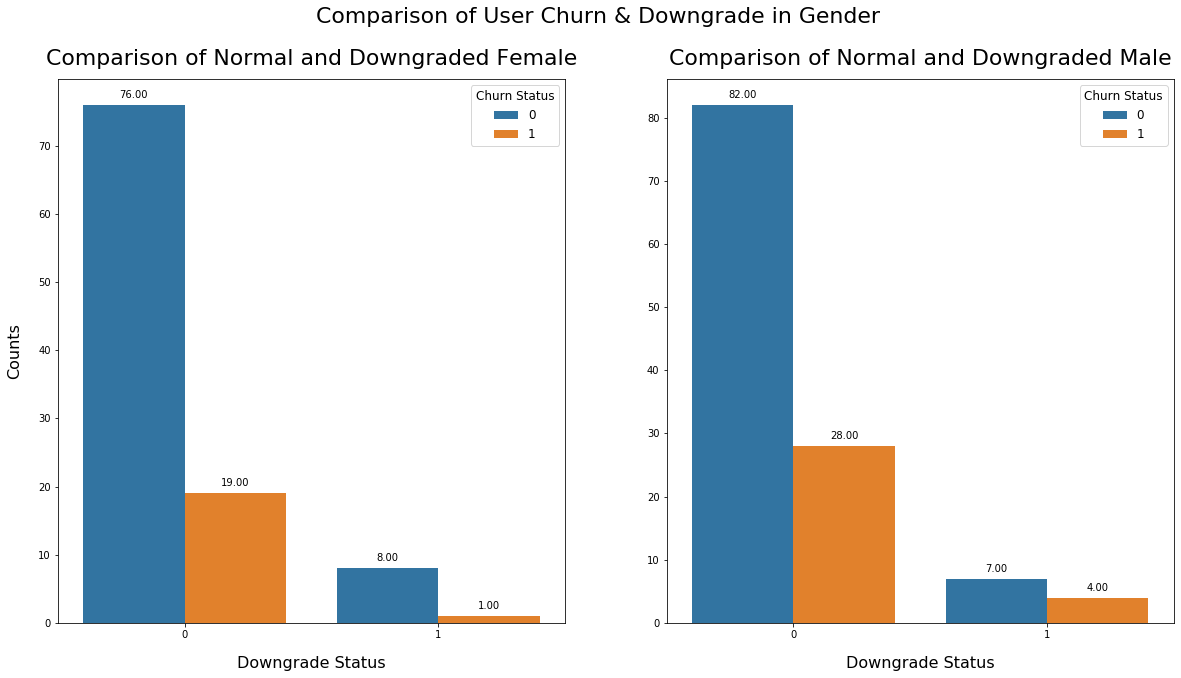

In [135]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.suptitle('Comparison of User Churn & Downgrade in Gender', fontsize=22)
barplot1('downgrade', 'counts', 'churn', churn_down_f, 'Comparison of Normal and Downgraded Female', 'Downgrade Status', 'Counts', 'Churn Status', 0, 'center')
plt.subplot(122)
barplot1('downgrade', 'counts', 'churn', churn_down_m, 'Comparison of Normal and Downgraded Male', 'Downgrade Status', '', 'Churn Status', 0, 'center')

In [136]:
churn_down_level = df3.drop_duplicates(subset='userId').groupby(["downgrade", "churn", "level"]).size().reset_index().rename(columns={0:'counts'})
churn_down_free = churn_down_level[churn_down_level['level'] == 'free']
churn_down_paid = churn_down_level[churn_down_level['level'] == 'paid']
churn_down_level

,downgrade,churn,level,counts
0,0,0,free,122
1,0,0,paid,36
2,0,1,free,40
3,0,1,paid,7
4,1,0,free,11
5,1,0,paid,4
6,1,1,free,4
7,1,1,paid,1


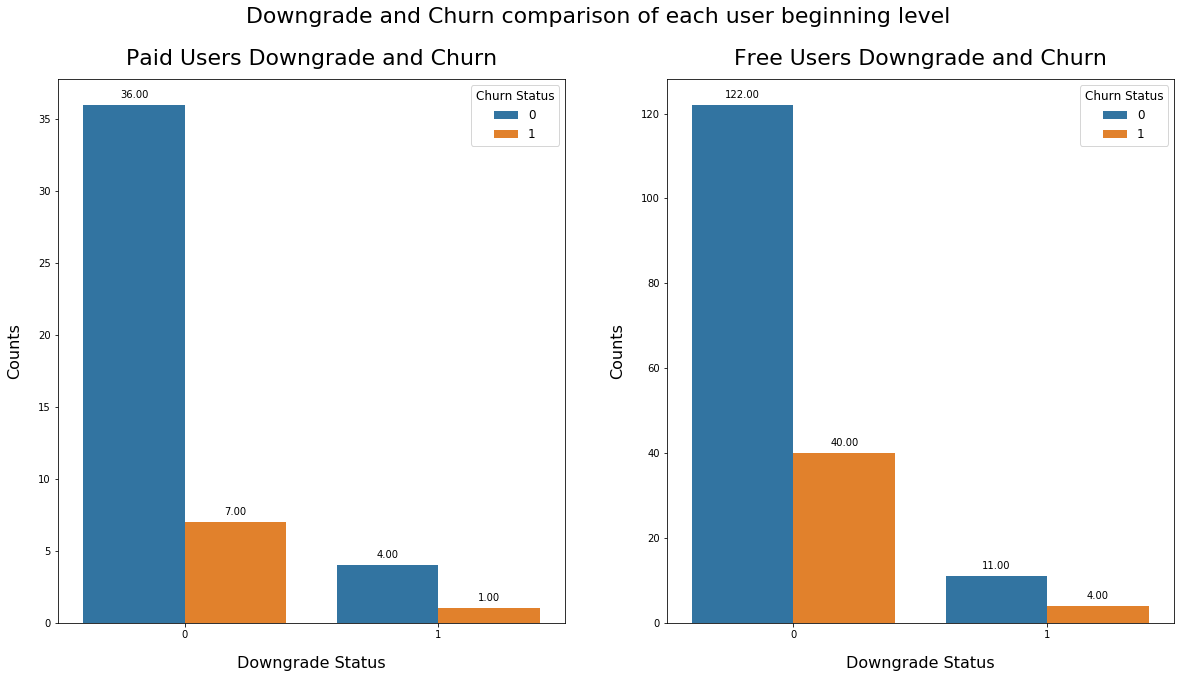

In [137]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.suptitle('Downgrade and Churn comparison of each user beginning level', fontsize=22)
g = sb.barplot(x='downgrade', y='counts', hue='churn', data=churn_down_paid)
plt.title('Paid Users Downgrade and Churn', fontsize=22, y=1.015)
plt.xlabel('Downgrade Status', fontsize=16,labelpad=16)
plt.ylabel('Counts', fontsize=16,labelpad=16)
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2.,
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
        textcoords = 'offset points')
leg = g.legend(prop={'size':12})
leg.set_title('Churn Status', prop={'size':12})
g= plt.gca()
plt.subplot(122)
g = sb.barplot(x='downgrade', y='counts', hue='churn', data=churn_down_free)
plt.title('Free Users Downgrade and Churn', fontsize=22, y=1.015)
plt.xlabel('Downgrade Status', fontsize=16,labelpad=16)
plt.ylabel('Counts', fontsize=16,labelpad=16)
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2.,
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
        textcoords = 'offset points')
leg = g.legend(prop={'size':12})
leg.set_title('Churn Status', prop={'size':12})
g= plt.gca()

So in this we can see that the portion of people downgraded and churned from each level. There are 7 people that churned and 1 people that downgrade first then churned from the paid level section. There are 40 people that churned and 4 people that churned after downgrading from the free level section. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features: 
#### Categoric Features: 
- Gender 
- User's OS 
- Location of the user 
- User's end Level 

#### Numeric Features: 
- Song Length 
- Thumbs up 
- Thumbs down 
- Number of playlists
- Invite Friends 
- User Lifetime

In [138]:
df3['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Name: page, dtype: int64

In [139]:
dfs= df

In [140]:
dfs.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year_month: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- week_day: string (nullable = true)
 |-- exp: string (nullable = true)
 |-- OS: string (nullable = true)
 |-- gen_os: string (nullable = true)
 |-- spe_o

#### Turning Gender into dummy variable 

In [141]:
gen_dict = {'M': '1', 'F': '0'}
dfs = dfs.replace(to_replace=gen_dict, subset=['gender'])
dfs = dfs.withColumn('gender', dfs['gender'].cast(IntegerType()))
dfs.select(['gender']).groupBy('gender').count().orderBy('count').show()

+------+------+
|gender| count|
+------+------+
|     1|123576|
|     0|154578|
+------+------+



In [142]:
gender_feat = dfs.select(['userId', 'gender']).dropDuplicates()

In [143]:
gender_feat.count()

225

#### Turning User OS specific into dummy variable 

In [144]:
os_name = dfs.select('spe_os').distinct().rdd.flatMap(lambda x: x).collect()

os_exp = [F.when(F.col('spe_os') == osdict, 1).otherwise(0).alias(osdict)
         for osdict in os_name]

os_feat = dfs.select('userId', *os_exp)
os_feat.show()

+------+----+------+-----------+-----+-------------+-----------+---+----------+---------+
|userId|iPad|iPhone|Windows 8.1|Linux|Windows Vista|Windows 8.0|Mac|Windows XP|Windows 7|
+------+----+------+-----------+-----+-------------+-----------+---+----------+---------+
|    30|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|     9|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|    30|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|     9|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|    30|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|     9|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|     9|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|    30|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|    30|  

In [145]:
os_feat= os_feat.dropDuplicates()
os_feat.show()

+------+----+------+-----------+-----+-------------+-----------+---+----------+---------+
|userId|iPad|iPhone|Windows 8.1|Linux|Windows Vista|Windows 8.0|Mac|Windows XP|Windows 7|
+------+----+------+-----------+-----+-------------+-----------+---+----------+---------+
|    35|   0|     0|          0|    0|            0|          0|  1|         0|        0|
|    66|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|    77|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|    94|   0|     0|          0|    0|            0|          1|  0|         0|        0|
|300002|   0|     0|          0|    0|            0|          0|  1|         0|        0|
|100006|   0|     0|          1|    0|            0|          0|  0|         0|        0|
|     5|   0|     0|          0|    0|            0|          0|  0|         0|        1|
|300022|   0|     0|          0|    1|            0|          0|  0|         0|        0|
|   102|  

#### Turning States into dummy variable 

In [146]:
state_name = dfs.select('state').distinct().rdd.flatMap(lambda x: x).collect()

state_exp = [F.when(F.col('state') == statedict, 1).otherwise(0).alias(statedict)
            for statedict in state_name]

state_feat = dfs.select('userId', *state_exp)
state_feat.show()

+------+------+------+---+------------+---+---+------+---------+------+---+---+---+---+------+---+---------+------+---+---+---+---+---+---+------+---+---+---------+---+---+---+------+------+------+---+---+---+------+------+---+---+------+------+---+------+---------+------+---+---+---+---+---+------------+---+------+---+---+---+---+
|userId| NE-IA| PA-NJ| WA| DC-VA-MD-WV| AL| MI| MN-WI| IL-IN-WI| MD-WV| NH| AK| AR| AZ| MA-NH| WV| TN-MS-AR| MO-IL| TN| NY| MD| OH| FL| IL| IL-MO| LA| CA| NY-NJ-PA| UT| TX| SC| MO-KS| OR-WA| UT-ID| OK| NV| IA| VA-NC| RI-MA| PA| OR| GA-AL| KY-IN| CT| TN-VA| OH-KY-IN| SC-NC| NJ| GA| MS| MT| CO| PA-NJ-DE-MD| VA| NC-SC| WI| KY| IN| NC|
+------+------+------+---+------------+---+---+------+---------+------+---+---+---+---+------+---+---------+------+---+---+---+---+---+---+------+---+---+---------+---+---+---+------+------+------+---+---+---+------+------+---+---+------+------+---+------+---------+------+---+---+---+---+---+------------+---+------+---+---+---+---

In [147]:
state_feat = state_feat.dropDuplicates()
state_feat.count()

225

#### Turning  end_level into dummy variable (excluded from downgrade analysis) 

Due to the high correlation between the end_level and the downgrade probability, this feature will be excluded from revenue churn analysis

In [148]:
end_dict = {'paid': '0', 'free': '1'}
dfs = dfs.replace(to_replace=end_dict, subset=['end_level'])
dfs = dfs.withColumn('end_level', dfs['end_level'].cast(IntegerType()))
dfs.select(['end_level']).groupBy('end_level').count().orderBy('count').show()

+---------+------+
|end_level| count|
+---------+------+
|        1| 28492|
|        0|249662|
+---------+------+



In [149]:
end_feat = dfs.select(['userId', 'end_level']).dropDuplicates()

In [150]:
end_feat.show(), end_feat.count()

+------+---------+
|userId|end_level|
+------+---------+
|    73|        0|
|    19|        0|
|200007|        0|
|    50|        0|
|100005|        0|
|200002|        0|
|    30|        0|
|     8|        0|
|100012|        1|
|     4|        0|
|200018|        0|
|    65|        0|
|   153|        0|
|    42|        0|
|    94|        0|
|    62|        0|
|   114|        0|
|   144|        0|
|    78|        0|
|    59|        0|
+------+---------+
only showing top 20 rows



(None, 225)

In [152]:
churn_df = dfs.select(['userId', col('churn').alias('label')]).dropDuplicates()
down_df = dfs.select(['userId', col('downgrade').alias('label')]).dropDuplicates()

### Numeric Features 
#### Song Length in all of their sessions

In [153]:
length_df = dfs.filter(dfs.page=='NextSong').select('userId', 'sessionId', 'length')
length_df = length_df.withColumn('sessions', (length_df.length/3600))
length_df = length_df.groupBy('userId', 'sessionId').sum('sessions')
length_df = length_df.groupBy('userId').agg(F.sum('sum(sessions)').alias('ses_hours')).na.fill(0)
length_df.show(), length_df.count()

+------+------------------+
|userId|         ses_hours|
+------+------------------+
|100010|18.594693708333335|
|200002|       26.11357665|
|   125|0.5803091944444445|
|    51|145.35440077777778|
|   124| 281.1978035527778|
|     7|10.565024194444442|
|    54|197.59581098333328|
|    15|132.58544605833333|
|   155| 55.21646997222222|
|100014| 18.80652002222222|
|   132| 134.1996955111111|
|   154| 5.738895530555555|
|   101|124.29555963055552|
|    11| 44.35276751111111|
|300017|249.27971672500001|
|   138| 142.3471896555555|
|    29|     209.588211825|
|    69| 79.46222934444445|
|100021|16.009215455555555|
|    42|244.94249059166665|
+------+------------------+
only showing top 20 rows



(None, 225)

#### Numeric Page Features 

In [154]:
df3['page'].value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cancellation Confirmation        52
Name: page, dtype: int64

In [155]:
page_df = dfs.groupBy('userId').pivot('page').count().na.fill(0)
page_df = page_df.select(['userId', 'Add Friend', 'Add to Playlist', 'Thumbs Down', 'Thumbs Up'])
page_df.show(), page_df.count()

+------+----------+---------------+-----------+---------+
|userId|Add Friend|Add to Playlist|Thumbs Down|Thumbs Up|
+------+----------+---------------+-----------+---------+
|200002|         4|              8|          6|       21|
|100010|         4|              7|          5|       17|
|   125|         0|              0|          0|        0|
|    51|        28|             52|         21|      100|
|   124|        74|            118|         41|      171|
|     7|         1|              5|          1|        7|
|    54|        33|             72|         29|      163|
|    15|        31|             59|         14|       81|
|   155|        11|             24|          3|       58|
|   132|        41|             38|         17|       96|
|100014|         6|              7|          3|       17|
|   154|         3|              1|          0|       11|
|    11|         6|             20|          9|       40|
|   101|        29|             61|         16|       86|
|   138|      

(None, 225)

#### User Subs age 

In [156]:
start_sub = dfs.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
end_sub = dfs.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
sub_df = start_sub.join(end_sub,'userId')
ticks_per_day = 1000 * 60 * 60 * 24 
sub_df = sub_df.select('userId', ((sub_df.end-sub_df.start)/ticks_per_day).alias('Subs Duration in Days'))
sub_df.show()

+------+---------------------+
|userId|Subs Duration in Days|
+------+---------------------+
|100010|    55.64365740740741|
|200002|    70.07462962962963|
|   125|    71.31688657407408|
|   124|   131.55591435185184|
|    51|   19.455844907407407|
|     7|    72.77818287037037|
|    15|   56.513576388888886|
|    54|   110.75168981481481|
|   155|   23.556018518518517|
|100014|    85.08340277777778|
|   132|     66.8891087962963|
|   154|   23.872037037037035|
|   101|           53.9659375|
|    11|   124.47825231481481|
|   138|    66.62668981481481|
|300017|    74.35851851851852|
|100021|    64.73886574074074|
|    29|   60.104050925925925|
|    69|    71.42444444444445|
|   112|    87.46262731481481|
+------+---------------------+
only showing top 20 rows



In [157]:
sub_df.count()

225

#### Standardize the numeric features 

In [158]:
df_num = length_df.join(page_df,'userId','outer') \
    .join(sub_df,'userId','outer') \

In [159]:
df_num.show()

+------+------------------+----------+---------------+-----------+---------+---------------------+
|userId|         ses_hours|Add Friend|Add to Playlist|Thumbs Down|Thumbs Up|Subs Duration in Days|
+------+------------------+----------+---------------+-----------+---------+---------------------+
|100010|18.594693708333335|         4|              7|          5|       17|    55.64365740740741|
|200002|       26.11357665|         4|              8|          6|       21|    70.07462962962963|
|   125|0.5803091944444445|         0|              0|          0|        0|    71.31688657407408|
|   124| 281.1978035527778|        74|            118|         41|      171|   131.55591435185184|
|    51|145.35440077777778|        28|             52|         21|      100|   19.455844907407407|
|     7|10.565024194444442|         1|              5|          1|        7|    72.77818287037037|
|    15|132.58544605833333|        31|             59|         14|       81|   56.513576388888886|
|    54|19

In [161]:
columns = df_num.columns[1:]
assemblers = [VectorAssembler(inputCols=[col],outputCol=col+'_vect') for col in columns]
scalers = [RobustScaler(inputCol=col+'_vect', outputCol=col+'_scaled', withScaling=True, withCentering=False,
                      lower=0.25, upper=0.75) for col in columns]
pipeline = Pipeline(stages=assemblers + scalers)
scaledmodel = pipeline.fit(df_num)
scaled_data = scaledmodel.transform(df_num)

#### Joining dataframes

In [162]:
scaled_data = scaled_data.select(['userId', 'ses_hours_scaled',
 'Add Friend_scaled',
 'Add to Playlist_scaled',
 'Thumbs Down_scaled',
 'Thumbs Up_scaled',
 'Subs Duration in Days_scaled'])
scaled_data.show()

+------+--------------------+--------------------+----------------------+--------------------+--------------------+----------------------------+
|userId|    ses_hours_scaled|   Add Friend_scaled|Add to Playlist_scaled|  Thumbs Down_scaled|    Thumbs Up_scaled|Subs Duration in Days_scaled|
+------+--------------------+--------------------+----------------------+--------------------+--------------------+----------------------------+
|100010|[0.1999618646052757]|[0.18181818181818...|  [0.18421052631578...|[0.3571428571428571]|[0.24285714285714...|        [1.3488542651279287]|
|200002|[0.28081771931024...|[0.18181818181818...|  [0.21052631578947...|[0.42857142857142...|               [0.3]|        [1.6986745202806002]|
|   125|[0.00624047431965...|               [0.0]|                 [0.0]|               [0.0]|               [0.0]|        [1.7287879897391267]|
|   124|[3.0239184362645433]|[3.3636363636363638]|  [3.1052631578947367]|[2.9285714285714284]|[2.4428571428571426]|        [3.1890

In [163]:
df_cate = gender_feat.join(os_feat,'userId','outer') \
    .join(state_feat,'userId','outer') \
    .join(end_feat,'userId','outer') 

df_cate.show(5)

+------+------+----+------+-----------+-----+-------------+-----------+---+----------+---------+------+------+---+------------+---+---+------+---------+------+---+---+---+---+------+---+---------+------+---+---+---+---+---+---+------+---+---+---------+---+---+---+------+------+------+---+---+---+------+------+---+---+------+------+---+------+---------+------+---+---+---+---+---+------------+---+------+---+---+---+---+---------+
|userId|gender|iPad|iPhone|Windows 8.1|Linux|Windows Vista|Windows 8.0|Mac|Windows XP|Windows 7| NE-IA| PA-NJ| WA| DC-VA-MD-WV| AL| MI| MN-WI| IL-IN-WI| MD-WV| NH| AK| AR| AZ| MA-NH| WV| TN-MS-AR| MO-IL| TN| NY| MD| OH| FL| IL| IL-MO| LA| CA| NY-NJ-PA| UT| TX| SC| MO-KS| OR-WA| UT-ID| OK| NV| IA| VA-NC| RI-MA| PA| OR| GA-AL| KY-IN| CT| TN-VA| OH-KY-IN| SC-NC| NJ| GA| MS| MT| CO| PA-NJ-DE-MD| VA| NC-SC| WI| KY| IN| NC|end_level|
+------+------+----+------+-----------+-----+-------------+-----------+---+----------+---------+------+------+---+------------+---+---+-

In [164]:
df_churn1 = scaled_data.join(df_cate,'userId','outer') \
    .join(churn_df,'userId','outer') \
    .drop('userId')

In [165]:
#needed to avoid error
df_churn1 = df_churn1.withColumnRenamed("Windows 8.1", "Windows 81")
df_churn1 = df_churn1.withColumnRenamed("Windows 8.0", "Windows 80")

In [166]:
df_churn1.columns

['ses_hours_scaled',
 'Add Friend_scaled',
 'Add to Playlist_scaled',
 'Thumbs Down_scaled',
 'Thumbs Up_scaled',
 'Subs Duration in Days_scaled',
 'gender',
 'iPad',
 'iPhone',
 'Windows 81',
 'Linux',
 'Windows Vista',
 'Windows 80',
 'Mac',
 'Windows XP',
 'Windows 7',
 ' NE-IA',
 ' PA-NJ',
 ' WA',
 ' DC-VA-MD-WV',
 ' AL',
 ' MI',
 ' MN-WI',
 ' IL-IN-WI',
 ' MD-WV',
 ' NH',
 ' AK',
 ' AR',
 ' AZ',
 ' MA-NH',
 ' WV',
 ' TN-MS-AR',
 ' MO-IL',
 ' TN',
 ' NY',
 ' MD',
 ' OH',
 ' FL',
 ' IL',
 ' IL-MO',
 ' LA',
 ' CA',
 ' NY-NJ-PA',
 ' UT',
 ' TX',
 ' SC',
 ' MO-KS',
 ' OR-WA',
 ' UT-ID',
 ' OK',
 ' NV',
 ' IA',
 ' VA-NC',
 ' RI-MA',
 ' PA',
 ' OR',
 ' GA-AL',
 ' KY-IN',
 ' CT',
 ' TN-VA',
 ' OH-KY-IN',
 ' SC-NC',
 ' NJ',
 ' GA',
 ' MS',
 ' MT',
 ' CO',
 ' PA-NJ-DE-MD',
 ' VA',
 ' NC-SC',
 ' WI',
 ' KY',
 ' IN',
 ' NC',
 'end_level',
 'label']

In [167]:
cols = ['ses_hours_scaled',
 'Add Friend_scaled',
 'Add to Playlist_scaled',
 'Thumbs Down_scaled',
 'Thumbs Up_scaled',
 'Subs Duration in Days_scaled',
 'gender',
 'iPad',
 'iPhone',
 'Windows 81',
 'Linux',
 'Windows Vista',
 'Windows 80',
 'Mac',
 'Windows XP',
 'Windows 7',
 ' NE-IA',
 ' PA-NJ',
 ' WA',
 ' DC-VA-MD-WV',
 ' AL',
 ' MI',
 ' MN-WI',
 ' IL-IN-WI',
 ' MD-WV',
 ' NH',
 ' AK',
 ' AR',
 ' AZ',
 ' MA-NH',
 ' WV',
 ' TN-MS-AR',
 ' MO-IL',
 ' TN',
 ' NY',
 ' MD',
 ' OH',
 ' FL',
 ' IL',
 ' IL-MO',
 ' LA',
 ' CA',
 ' NY-NJ-PA',
 ' UT',
 ' TX',
 ' SC',
 ' MO-KS',
 ' OR-WA',
 ' UT-ID',
 ' OK',
 ' NV',
 ' IA',
 ' VA-NC',
 ' RI-MA',
 ' PA',
 ' OR',
 ' GA-AL',
 ' KY-IN',
 ' CT',
 ' TN-VA',
 ' OH-KY-IN',
 ' SC-NC',
 ' NJ',
 ' GA',
 ' MS',
 ' MT',
 ' CO',
 ' PA-NJ-DE-MD',
 ' VA',
 ' NC-SC',
 ' WI',
 ' KY',
 ' IN',
 ' NC',
 'end_level']
assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_churn2 = assembler.transform(df_churn1)

In [168]:
df_down1 = scaled_data.join(df_cate,'userId','outer') \
    .join(down_df,'userId','outer') \
    .drop('userId', 'end_level') 

In [169]:
df_down1 = df_down1.withColumnRenamed("Windows 8.1", "Windows 81")
df_down1 = df_down1.withColumnRenamed("Windows 8.0", "Windows 80")

In [170]:
cols = ['ses_hours_scaled',
 'Add Friend_scaled',
 'Add to Playlist_scaled',
 'Thumbs Down_scaled',
 'Thumbs Up_scaled',
 'Subs Duration in Days_scaled',
 'gender',
 'iPad',
 'iPhone',
 'Windows 81',
 'Linux',
 'Windows Vista',
 'Windows 80',
 'Mac',
 'Windows XP',
 'Windows 7',
 ' NE-IA',
 ' PA-NJ',
 ' WA',
 ' DC-VA-MD-WV',
 ' AL',
 ' MI',
 ' MN-WI',
 ' IL-IN-WI',
 ' MD-WV',
 ' NH',
 ' AK',
 ' AR',
 ' AZ',
 ' MA-NH',
 ' WV',
 ' TN-MS-AR',
 ' MO-IL',
 ' TN',
 ' NY',
 ' MD',
 ' OH',
 ' FL',
 ' IL',
 ' IL-MO',
 ' LA',
 ' CA',
 ' NY-NJ-PA',
 ' UT',
 ' TX',
 ' SC',
 ' MO-KS',
 ' OR-WA',
 ' UT-ID',
 ' OK',
 ' NV',
 ' IA',
 ' VA-NC',
 ' RI-MA',
 ' PA',
 ' OR',
 ' GA-AL',
 ' KY-IN',
 ' CT',
 ' TN-VA',
 ' OH-KY-IN',
 ' SC-NC',
 ' NJ',
 ' GA',
 ' MS',
 ' MT',
 ' CO',
 ' PA-NJ-DE-MD',
 ' VA',
 ' NC-SC',
 ' WI',
 ' KY',
 ' IN',
 ' NC']
assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_down2 = assembler.transform(df_down1)

In [171]:
df_down2.show(2)

+--------------------+--------------------+----------------------+--------------------+--------------------+----------------------------+------+----+------+----------+-----+-------------+----------+---+----------+---------+------+------+---+------------+---+---+------+---------+------+---+---+---+---+------+---+---------+------+---+---+---+---+---+---+------+---+---+---------+---+---+---+------+------+------+---+---+---+------+------+---+---+------+------+---+------+---------+------+---+---+---+---+---+------------+---+------+---+---+---+---+-----+--------------------+
|    ses_hours_scaled|   Add Friend_scaled|Add to Playlist_scaled|  Thumbs Down_scaled|    Thumbs Up_scaled|Subs Duration in Days_scaled|gender|iPad|iPhone|Windows 81|Linux|Windows Vista|Windows 80|Mac|Windows XP|Windows 7| NE-IA| PA-NJ| WA| DC-VA-MD-WV| AL| MI| MN-WI| IL-IN-WI| MD-WV| NH| AK| AR| AZ| MA-NH| WV| TN-MS-AR| MO-IL| TN| NY| MD| OH| FL| IL| IL-MO| LA| CA| NY-NJ-PA| UT| TX| SC| MO-KS| OR-WA| UT-ID| OK| NV| IA|

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [173]:
# https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio
train, rest = df_churn2.randomSplit([0.6, 0.4], seed=139)
validation, test = rest.randomSplit([0.5, 0.5], seed=139)

In [174]:
train1, rest1 = df_down2.randomSplit([0.6, 0.4], seed=139)
validation1, test1 = rest1.randomSplit([0.5, 0.5], seed=139)

In [174]:
train2, valid2, test2 = df_churn2.randomSplit([0.6, 0.2, 0.2], seed=139)
train3, valid3, test3 = df_down2.randomSplit([0.6, 0.2, 0.2], seed=139)

### Hyperparameter Tuning 

#### Churn Test

#### Downgrade test

### Feature Importance of GBT Model 

After managed to get the accuracy, we will get list of features that affect the model heavily 

we can see the list of important features that give impact here such as higher session hours is the most important features in determining whether user will churn or not 

We can see that in downgrade, adding friends activities, user lifetime, user total listened songs of all sessions, and thumbs down activities have the most impact in the determining whether user will downgrade or not. 

### Performance of reduced features model 

### Churn Validation 

We will try first to validate which model algorithm that have the best metrics: PR AUCand f-1 score due to our imbalanced data. 

the PR AUC have relative threshold depending on the fraction of positive outcomes. For the churn, since we have 52 positive outcome out of 225, the PR AUC Threshold will be 0.23.

In [172]:
def validation_model(algo, df_train, df_valid, title): 
    algorithm = algo()

    paramGrid = ParamGridBuilder() \
        .build()

    crossval = CrossValidator(estimator=algorithm,
                              evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR'), 
                              estimatorParamMaps=paramGrid,
                              numFolds=3)
    cvModel = crossval.fit(df_train)
    results = cvModel.transform(df_valid)
    evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
    evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    print(title)
    print('area under ROC: %f' % evaluatorb.evaluate(results, {evaluatorb.metricName: "areaUnderROC"}))
    print('area under PR: %f' % evaluatorb.evaluate(results, {evaluatorb.metricName: "areaUnderPR"}))
    print('Accuracy: %f' % evaluatorm.evaluate(results, {evaluatorm.metricName: "accuracy"}))
    print('F-1 Score: %f' % evaluatorm.evaluate(results, {evaluatorm.metricName: "f1"}))
    print('wPrecision: %f' % evaluatorm.evaluate(results, {evaluatorm.metricName: "weightedPrecision"}))
    print('wRecall: %f' % evaluatorm.evaluate(results, {evaluatorm.metricName: "weightedRecall"}))

In [190]:
validation_model(LogisticRegression, train2, valid2, 'Logistic Regression Metrics:')

Logistic Regression Metrics:
area under ROC: 0.459375
area under PR: 0.204329
Accuracy: 0.595238
F-1 Score: 0.601663
wPrecision: 0.608574
wRecall: 0.595238


In [191]:
validation_model(GBTClassifier, train2, valid2, 'Gradient Boosted Trees Metrics:')

Gradient Boosted Trees Metrics:
area under ROC: 0.756250
area under PR: 0.493407
Accuracy: 0.785714
F-1 Score: 0.794420
wPrecision: 0.811292
wRecall: 0.785714


In [177]:
validation_model(LinearSVC, train2, valid2, 'Support Vector Machine Metrics:')

Support Vector Machine Metrics:
area under ROC: 0.409375
area under PR: 0.162143
Accuracy: 0.571429
F-1 Score: 0.571429
wPrecision: 0.571429
wRecall: 0.571429


In [178]:
validation_model(RandomForestClassifier, train2, valid2, 'Random Forest Metrics:')

Random Forest Metrics:
area under ROC: 0.500000
area under PR: 0.238095
Accuracy: 0.761905
F-1 Score: 0.658945
wPrecision: 0.580499
wRecall: 0.761905


In [179]:
validation_model(NaiveBayes, train2, valid2, 'NaiveBayes Metrics:')

NaiveBayes Metrics:
area under ROC: 0.453125
area under PR: 0.119048
Accuracy: 0.690476
F-1 Score: 0.622401
wPrecision: 0.566545
wRecall: 0.690476


### Downgrade Validation 

the PR AUC have relative threshold depending on the fraction of positive outcomes. For the downgrade, since we have 20 positive outcome out of 225, the PR AUC Threshold will be 0.08

In [267]:
validation_model(LogisticRegression, train3, valid3, 'Logistic Regression Metrics:')

Logistic Regression Metrics:
area under ROC: 0.447368
area under PR: 0.047619
Accuracy: 0.809524
F-1 Score: 0.809524
wPrecision: 0.809524
wRecall: 0.809524


In [268]:
validation_model(GBTClassifier, train3, valid3, 'Gradient Boosted Trees Metrics:')

Gradient Boosted Trees Metrics:
area under ROC: 0.572368
area under PR: 0.160714
Accuracy: 0.833333
F-1 Score: 0.841481
wPrecision: 0.850450
wRecall: 0.833333


In [270]:
validation_model(LinearSVC, train3, valid3, 'Support Vector Machine Metrics:')

Support Vector Machine Metrics:
area under ROC: 0.473684
area under PR: 0.047619
Accuracy: 0.857143
F-1 Score: 0.835165
wPrecision: 0.814286
wRecall: 0.857143


In [272]:
validation_model(RandomForestClassifier, train3, valid3, 'Random Forest Metrics:')

Random Forest Metrics:
area under ROC: 0.500000
area under PR: 0.095238
Accuracy: 0.904762
F-1 Score: 0.859524
wPrecision: 0.818594
wRecall: 0.904762


In [273]:
validation_model(NaiveBayes, train3, valid3, 'NaiveBayes Metrics:')

NaiveBayes Metrics:
area under ROC: 0.500000
area under PR: 0.095238
Accuracy: 0.904762
F-1 Score: 0.859524
wPrecision: 0.818594
wRecall: 0.904762


#### Results:

|       Algorithm        | Area Under PRC (0.23) | Churn F-1 Score | Area Under PRC (0.08) | Downgrade F-1 Score |
| :--------------------: | :-------------------: | :-------------: | :-------------------: | :-----------------: |
| Logistic Regression    |         0.2043        |     0.6017      |         0.0476        |        0.8095       |
| Gradient Boosted Trees |         0.4934        |     0.7944      |         0.1607        |        0.8415       |
| Support Vector Machine |         0.1621        |     0.5714      |         0.0476        |        0.8352       |
| Random Forest          |         0.2381        |     0.6590      |         0.2381        |        0.8595       |
| Naive Bayes            |         0.1191        |     0.6224      |         0.2381        |        0.8595       |

we will use both Gradient Boosted trees for both churn and downgrade 

### Hyperparameter Tuning 

#### Churn Test

In [219]:
gbt = GBTClassifier(seed=139)

paramGrid_c = ParamGridBuilder() \
    .addGrid(gbt.maxBins,[16, 32]) \
    .addGrid(gbt.maxDepth,[4, 5]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR'), 
                          estimatorParamMaps=paramGrid_c,
                          numFolds=3)

In [220]:
cvModel_gbtc = crossval_gbt.fit(train2)
cvModel_gbtc.avgMetrics, paramGrid_c

([0.36718858515962727,
  0.3313011613011828,
  0.29728990645742526,
  0.3509801129624456],
 [{Param(parent='GBTClassifier_311fd3ecd303', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_311fd3ecd303', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
  {Param(parent='GBTClassifier_311fd3ecd303', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_311fd3ecd303', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
  {Param(parent='GBTClassifier_311fd3ecd303', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must b

In [221]:
results_gbtc = cvModel_gbtc.transform(valid2) 
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_gbtc, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_gbtc, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.656250
area under PR: 0.400433
Accuracy: 0.738095
F-1 Score: 0.742252
wPrecision: 0.747242
wRecall: 0.738095


In [222]:
gbt_c = GBTClassifier(seed=139, maxDepth=4, maxBins=16)
gbt_modelc = gbt_c.fit(train2)
results_bestc = gbt_modelc.transform(test2)

In [223]:
#best churn test with valid parameter (used)
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_bestc, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_bestc, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_gbtc, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.591892
area under PR: 0.297163
Accuracy: 0.738095
F-1 Score: 0.742252
wPrecision: 0.747242
wRecall: 0.738095


#### Downgrade Test

In [204]:
gbt = GBTClassifier(seed=139)

paramGrid_d = ParamGridBuilder() \
    .addGrid(gbt.maxBins,[16, 32]) \
    .addGrid(gbt.maxDepth,[4, 5]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR'), 
                          estimatorParamMaps=paramGrid_d,
                          numFolds=3)

In [205]:
cvModel_gbtd = crossval_gbt.fit(train3)
cvModel_gbtd.avgMetrics, paramGrid_d

([0.07083262458666965,
  0.07487563749014244,
  0.06944419296822367,
  0.09254997616328187],
 [{Param(parent='GBTClassifier_f9e09039b0e5', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_f9e09039b0e5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
  {Param(parent='GBTClassifier_f9e09039b0e5', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_f9e09039b0e5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
  {Param(parent='GBTClassifier_f9e09039b0e5', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must

In [206]:
results_gbtd = cvModel_gbtd.transform(valid3) 
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_gbtd, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_gbtd, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_gbtd, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_gbtd, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_gbtd, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_gbtd, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.572368
area under PR: 0.160714
Accuracy: 0.833333
F-1 Score: 0.841481
wPrecision: 0.850450
wRecall: 0.833333


In [207]:
gbt_d = GBTClassifier(seed=139, maxDepth=5, maxBins=32)
gbt_modeld = gbt_d.fit(train3)
results_bestd = gbt_modeld.transform(test3)

In [208]:
#best down test with valid parameter (used)
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_bestd, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_bestd, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_bestd, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_bestd, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_bestd, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_bestd, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.621212
area under PR: 0.154610
Accuracy: 0.872340
F-1 Score: 0.886813
wPrecision: 0.904357
wRecall: 0.872340


#### Results:

|                        | Area Under PRC (0.23) | Churn F-1 Score | Area Under PRC (0.08) | Downgrade F-1 Score |
| :--------------------: | :-------------------: | :-------------: | :-------------------: | :-----------------: |
| Tuned Model Results    |         0.2972        |     0.7423      |         0.1546        |        0.8868       |

### Feature Importance of GBT Model 

After managed to get the accuracy, we will get list of features that affect the model heavily  

In [209]:
#https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
def ExtractFeature(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [229]:
# using best churn model with valid parameter
df_finalc = ExtractFeature(gbt_modelc.featureImportances, results_bestc, "features")
df_finalc = df_finalc[df_finalc['score'] >= 0.01].reset_index().drop(['index', 'idx'], axis=1) 
df_finalc

,name,score
0,Add Friend_scaled_0,0.169247
1,Thumbs Down_scaled_0,0.105215
2,Subs Duration in Days_scaled_0,0.097903
3,ses_hours_scaled_0,0.090277
4,iPhone,0.072241
5,Windows 7,0.051980
6,Add to Playlist_scaled_0,0.044970
7,WA,0.043502
8,MO-IL,0.039768
9,SC,0.033955


In [299]:
df_finalc['cumsum'] = df_finalc['score'].cumsum()
df_finalc

,name,score,cumsum
0,Add Friend_scaled_0,0.169247,0.169247
1,Thumbs Down_scaled_0,0.105215,0.274461
2,Subs Duration in Days_scaled_0,0.097903,0.372365
3,ses_hours_scaled_0,0.090277,0.462642
4,iPhone,0.072241,0.534882
5,Windows 7,0.051980,0.586862
6,Add to Playlist_scaled_0,0.044970,0.631832
7,WA,0.043502,0.675334
8,MO-IL,0.039768,0.715102
9,SC,0.033955,0.749057


In [212]:
def barplot2(height, width, xcol, ycol, dataframe, titl, xtitl, ytitl, rotate, align): 
    base_color = sb.color_palette()[0]
    plt.figure(figsize=(height, width))
    g = sb.barplot(x=xcol, y=ycol, data=dataframe, color=base_color)
    plt.title(titl, fontsize=22, y=1.015)
    plt.xlabel(xtitl, fontsize=16,labelpad=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=rotate, horizontalalignment=align)
    plt.ylabel(ytitl, fontsize=16,labelpad=16)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2.,
            p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
            textcoords = 'offset points')
    leg = g.legend(prop={'size':12})
    g= plt.gca()

No handles with labels found to put in legend.


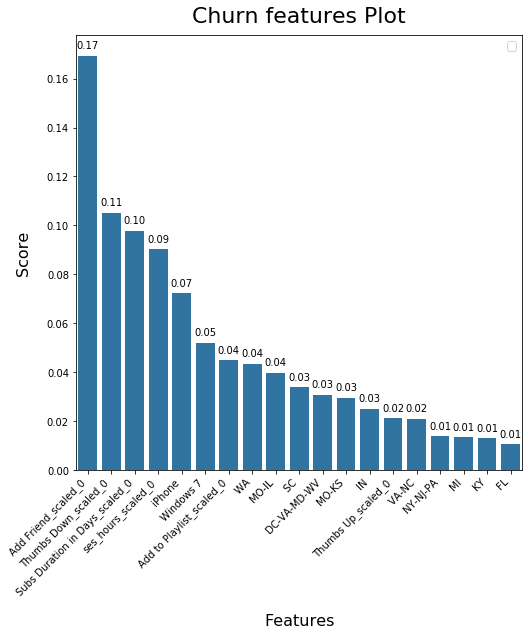

In [230]:
barplot2(8,8, 'name', 'score' , df_finalc, 'Churn features Plot', 'Features', 'Score',  45, 'right') 

we can see the list of important features that give impact here such as higher session hours is the most important features in determining whether user will churn or not 

In [231]:
df_finald = ExtractFeature(gbt_modeld.featureImportances, results_bestd, "features")
df_finald = df_finald[df_finald['score'] >= 0.01].reset_index().drop(['index', 'idx'], axis=1) 
df_finald

,name,score
0,Subs Duration in Days_scaled_0,0.262777
1,Thumbs Down_scaled_0,0.180360
2,Add Friend_scaled_0,0.146520
3,ses_hours_scaled_0,0.100680
4,PA-NJ-DE-MD,0.056168
5,Add to Playlist_scaled_0,0.052344
6,CA,0.036620
7,Thumbs Up_scaled_0,0.025351
8,MO-IL,0.023412
9,DC-VA-MD-WV,0.022832


In [300]:
df_finald['cumsum'] = df_finald['score'].cumsum()
df_finald

,name,score,cumsum
0,Subs Duration in Days_scaled_0,0.262777,0.262777
1,Thumbs Down_scaled_0,0.180360,0.443137
2,Add Friend_scaled_0,0.146520,0.589656
3,ses_hours_scaled_0,0.100680,0.690336
4,PA-NJ-DE-MD,0.056168,0.746505
5,Add to Playlist_scaled_0,0.052344,0.798849
6,CA,0.036620,0.835468
7,Thumbs Up_scaled_0,0.025351,0.860819
8,MO-IL,0.023412,0.884231
9,DC-VA-MD-WV,0.022832,0.907063


No handles with labels found to put in legend.


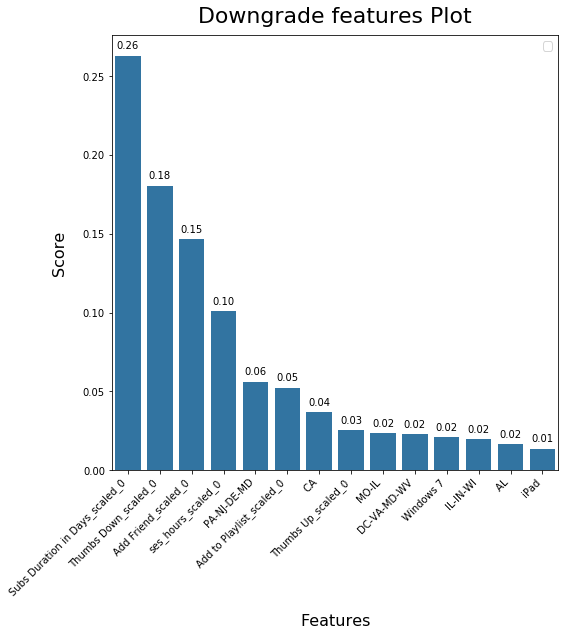

In [232]:
barplot2(8,8, 'name', 'score' , df_finald, 'Downgrade features Plot', 'Features', 'Score',  45, 'right') 

We can see that in downgrade, adding friends activities, user lifetime, user total listened songs of all sessions, and thumbs down activities have the most impact in the determining whether user will downgrade or not. 

### Performance of reduced features model 

In [335]:
finalcolc = np.array(df_finalc[df_finalc['cumsum'] <= 0.75]['name'])
finalcolc

array(['Add Friend_scaled_0', 'Thumbs Down_scaled_0',
       'Subs Duration in Days_scaled_0', 'ses_hours_scaled_0', 'iPhone',
       'Windows 7', 'Add to Playlist_scaled_0', ' WA', ' MO-IL', ' SC'],
      dtype=object)

In [337]:
featcol = np.append(finalcolc,['label'])
featcol

array(['Add Friend_scaled_0', 'Thumbs Down_scaled_0',
       'Subs Duration in Days_scaled_0', 'ses_hours_scaled_0', 'iPhone',
       'Windows 7', 'Add to Playlist_scaled_0', ' WA', ' MO-IL', ' SC',
       'label'], dtype=object)

In [243]:
featc_col = ['Add Friend_scaled', 'Thumbs Down_scaled',
       'Subs Duration in Days_scaled', 'ses_hours_scaled', 'iPhone',
       'Windows 7', 'Add to Playlist_scaled', ' WA', ' MO-IL', ' SC', 'label']

featc_col1 = ['Add Friend_scaled', 'Thumbs Down_scaled',
       'Subs Duration in Days_scaled', 'ses_hours_scaled', 'iPhone',
       'Windows 7', 'Add to Playlist_scaled', ' WA', ' MO-IL', ' SC']

df_redc = df_churn1.select(featc_col)
assembler = VectorAssembler(inputCols=featc_col1, outputCol="features")
df_churnred = assembler.transform(df_redc)

In [244]:
trainrc, validrc, testrc = df_churnred.randomSplit([0.6, 0.2, 0.2], seed=139)

In [236]:
#best model churn testrc with valid param
gbt_redc = GBTClassifier(seed=139, maxDepth=4, maxBins=16)
gbt_modelredc= gbt_redc.fit(trainrc)
results_redc = gbt_modelredc.transform(testrc)

In [237]:
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.626263
area under PR: 0.415377
Accuracy: 0.765957
F-1 Score: 0.752161
wPrecision: 0.745499
wRecall: 0.765957


In [305]:
gbt = GBTClassifier(seed=139)

paramGrid_c = ParamGridBuilder() \
    .addGrid(gbt.maxBins,[16, 32]) \
    .addGrid(gbt.maxDepth,[4, 5]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR'), 
                          estimatorParamMaps=paramGrid_c,
                          numFolds=3)

In [306]:
cvModel_gbtc = crossval_gbt.fit(trainrc)
cvModel_gbtc.avgMetrics, paramGrid_c

([0.44649228057265694,
  0.40041297022032013,
  0.4470315853810481,
  0.4689851865667989],
 [{Param(parent='GBTClassifier_2798007ba3cd', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_2798007ba3cd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
  {Param(parent='GBTClassifier_2798007ba3cd', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_2798007ba3cd', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
  {Param(parent='GBTClassifier_2798007ba3cd', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must b

In [311]:
cvModel_gbtc.bestModel.extractParamMap()

{Param(parent='GBTClassifier_2798007ba3cd', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_2798007ba3cd', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_2798007ba3cd', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

In [314]:
gbt_modelredc = cvModel_gbtc.bestModel
results_redc = gbt_modelredc.transform(testrc)

In [315]:
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.556818
area under PR: 0.284258
Accuracy: 0.659574
F-1 Score: 0.668896
wPrecision: 0.680273
wRecall: 0.659574


In [245]:
#best model churn testrc with valid param with 75% weight on feature importance
gbt_redc = GBTClassifier(seed=139, maxDepth=4, maxBins=16)
gbt_modelredc= gbt_redc.fit(trainrc)
results_redc = gbt_modelredc.transform(testrc)

In [246]:
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.671717
area under PR: 0.467870
Accuracy: 0.787234
F-1 Score: 0.779471
wPrecision: 0.775040
wRecall: 0.787234


In [312]:
#best model churn testrc with valid param with 75% weight on feature importance
gbt_redc = GBTClassifier(seed=139, maxDepth=5, maxBins=16)
gbt_modelredc= gbt_redc.fit(trainrc)
results_redc = gbt_modelredc.transform(testrc)

In [313]:
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_redc, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_redc, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.626263
area under PR: 0.415377
Accuracy: 0.765957
F-1 Score: 0.752161
wPrecision: 0.745499
wRecall: 0.765957


In [302]:
finalcold = np.array(df_finald[df_finald['cumsum'] <= 0.75]['name'])
finalcold

array(['Subs Duration in Days_scaled_0', 'Thumbs Down_scaled_0',
       'Add Friend_scaled_0', 'ses_hours_scaled_0', ' PA-NJ-DE-MD'],
      dtype=object)

In [247]:
featd_col = ['Subs Duration in Days_scaled', 'Thumbs Down_scaled',
       'Add Friend_scaled', 'ses_hours_scaled', ' PA-NJ-DE-MD', 'label']

featd_col1 = ['Subs Duration in Days_scaled', 'Thumbs Down_scaled',
       'Add Friend_scaled', 'ses_hours_scaled', ' PA-NJ-DE-MD']

df_redd = df_down1.select(featd_col)
assembler = VectorAssembler(inputCols=featd_col1, outputCol="features")
df_downred = assembler.transform(df_redd)

In [248]:
trainrd, validrd, testrd = df_downred.randomSplit([0.6, 0.2, 0.2], seed=139)

In [294]:
gbt = GBTClassifier(seed=139)

paramGrid_d = ParamGridBuilder() \
    .addGrid(gbt.maxBins,[16, 32]) \
    .addGrid(gbt.maxDepth,[4, 5]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR'), 
                          estimatorParamMaps=paramGrid_d,
                          numFolds=3)

In [295]:
cvModel_gbtd = crossval_gbt.fit(trainrd)
cvModel_gbtd.avgMetrics, paramGrid_d

([0.1323977275655384,
  0.18612012064377795,
  0.11684365929688112,
  0.09560420761094063],
 [{Param(parent='GBTClassifier_6e5c3e554c82', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_6e5c3e554c82', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4},
  {Param(parent='GBTClassifier_6e5c3e554c82', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16,
   Param(parent='GBTClassifier_6e5c3e554c82', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5},
  {Param(parent='GBTClassifier_6e5c3e554c82', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must 

In [292]:
#best model down testrd with valid param 
gbt_redd = GBTClassifier(seed=139, maxDepth=5, maxBins=16)
gbt_modelredd= gbt_redd.fit(trainrd)
results_redd = gbt_modelredd.transform(testrd)

In [293]:
evaluatorb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")
evaluatorm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('area under ROC: %f' % evaluatorb.evaluate(results_redd, {evaluatorb.metricName: "areaUnderROC"}))
print('area under PR: %f' % evaluatorb.evaluate(results_redd, {evaluatorb.metricName: "areaUnderPR"}))
print('Accuracy: %f' % evaluatorm.evaluate(results_redd, {evaluatorm.metricName: "accuracy"}))
print('F-1 Score: %f' % evaluatorm.evaluate(results_redd, {evaluatorm.metricName: "f1"}))
print('wPrecision: %f' % evaluatorm.evaluate(results_redd, {evaluatorm.metricName: "weightedPrecision"}))
print('wRecall: %f' % evaluatorm.evaluate(results_redd, {evaluatorm.metricName: "weightedRecall"}))

Gradient Boosted Trees Metrics:
area under ROC: 0.977778
area under PR: 0.500000
Accuracy: 0.957447
F-1 Score: 0.964055
wPrecision: 0.978723
wRecall: 0.957447


#### Results:

|                        | Area Under PRC (0.23) | Churn F-1 Score | Area Under PRC (0.08) | Downgrade F-1 Score |
| :--------------------: | :-------------------: | :-------------: | :-------------------: | :-----------------: |
| Tuned Model Results    |         0.2972        |     0.7423      |         0.1546        |        0.8868       |
| Reduced Model Results  |         0.4154        |     0.7522      |         0.5000        |        0.9641       |

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post. 


### Improvement 
- More datasets (of course!) 
- Experimenting with more features definition and sampling method
- Exprimenting more with the parameters of the models and multiple computers distribution 